In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories, plot_reconstructed_data_KS, plot_latent_states_KS 
from tools.ae_v6 import Autoencoder

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-01-21 05:33:53.071589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-21 05:33:53.072190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-21 05:33:53.147262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-21 05:33:53.147727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-21 05:33:53.148109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # loading data directory
    data_dir_idx = '005'

    # making ae save directory
    dir_name_ae = os.getcwd() + dir_sep + 'saved_ae'
    if not os.path.isdir(dir_name_ae):
        os.makedirs(dir_name_ae)

    counter = 0
    while True:
        dir_check = 'ae_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ae + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ae = dir_name_ae + dir_sep + dir_check
    os.makedirs(dir_name_ae)
    os.makedirs(dir_name_ae+dir_sep+'plots')
else:
    # some paramaters
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_015'.format(ds=dir_sep)

    with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))
    data_dir_idx = params_dict['data_dir_idx']
    normalizeforae_flag = params_dict['normalizeforae_flag']
    normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
    if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_ae:', dir_name_ae)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
        save_dir=None,
        xlabel=r'Time',
        ylabel=r'$x$',
        ax_titles_list=None
    ):

    n = len(boundary_idx_arr)
    num_digits_n = int(np.log10(n)+1)

    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')
        if ax_titles_list is not None:
            ax.title.set_text(ax_titles_list[i])
        else:
            ax.title.set_text(r'Case '+str(i+1))

        plt.colorbar(im)
        if save_dir is not None:
            fig.savefig(save_dir+'/Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
            fig.clear()
            plt.close()
        else:
            plt.show()
            print('')

        prev_idx = next_idx

    # '''

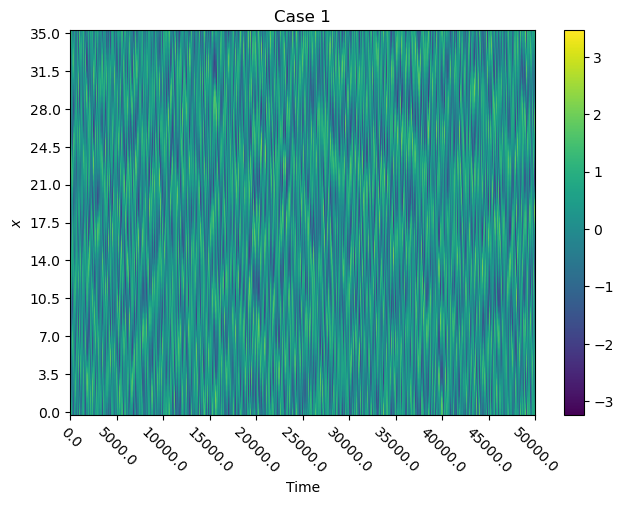

In [15]:
temp = boundary_idx_arr[0] + np.sum(boundary_idx_arr[1:] - boundary_idx_arr[0:-1])
temp /= len(boundary_idx_arr)
temp *= delta_t
chosen_interval = temp//10
sn = np.format_float_scientific(chosen_interval, exp_digits=4)
snap = np.max([0.1, 25*np.round(10*float(sn[0:-6])/25)/10])
snap *= float('1'+sn[-6:])
xticks_snapto = int(snap*np.round(chosen_interval/snap))

plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=xticks_snapto)

In [16]:
# dealing with normalizing the data before feeding into autoencoder
if behaviour == 'initialiseAndTrainFromScratch':
    # normalize data before feeding into autoencoder?
    normalizeforae_flag = True
    normalization_type = 'stddev' # could be 'stddev' or 'minmax'
    stddev_multiplier = 3
    
    ae_data_with_params = False # whether to feed in the parameters to the AE along with the data?

    normalization_constant_arr_aedata = None
    if normalizeforae_flag == True:
        normalization_constant_arr_aedata = np.empty(shape=(2, numpoints_xgrid), dtype=FTYPE)
        if normalization_type == 'stddev':
            for i in range(numpoints_xgrid):
                sample_mean = np.mean(all_data[:, i])
                sample_std = np.std(all_data[:, i])
                normalization_constant_arr_aedata[0, i] = sample_mean
                normalization_constant_arr_aedata[1, i] = stddev_multiplier*sample_std
        elif normalization_type == 'minmax':
            for i in range(numpoints_xgrid):
                sample_min = np.min(all_data[:, i])
                sample_max = np.max(all_data[:, i])
                if sample_max - sample_min == 0:
                    sample_min = sample_min - 0.5
                    sample_max = sample_min + 1
                normalization_constant_arr_aedata[0, i] = sample_min
                normalization_constant_arr_aedata[1, i] = sample_max - sample_min
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]
            
    # saving sim data
    ae_data = {
        'data_dir_idx':data_dir_idx,
        'normalizeforae_flag':normalizeforae_flag,
        'normalization_constant_arr_aedata':normalization_constant_arr_aedata,
        'normalization_type':normalization_type,
        'stddev_multiplier':stddev_multiplier,
        'ae_data_with_params':ae_data_with_params,
        'module':Autoencoder.__module__,
        'covmat_loss_used':True,
    }
    with open(dir_name_ae+dir_sep+'ae_data.txt', 'w') as f:
        f.write(str(ae_data))
    np.savez(
        dir_name_ae+dir_sep+'normalization_data',
        normalization_constant_arr_aedata=[normalization_constant_arr_aedata],
    )
else:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]
            
time_stddev = np.std(all_data, axis=0)
if ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
    time_stddev = time_stddev[0:numpoints_xgrid]
else:
    time_stddev[numpoints_xgrid:] = 1.0

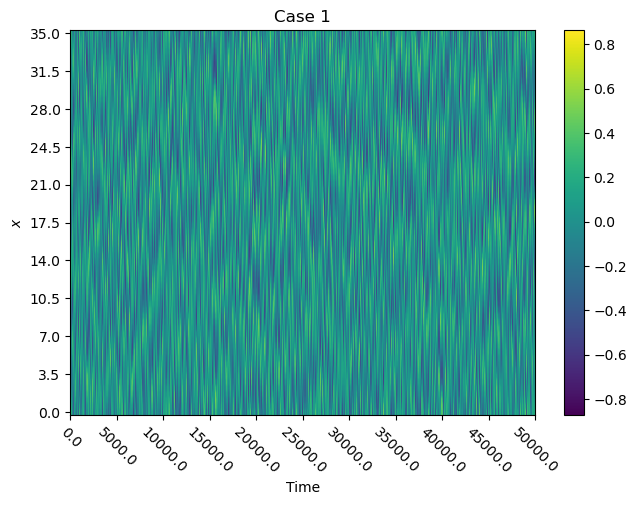

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=xticks_snapto)

In [18]:
num_tsteps_to_take = 1*int(15.5/0.1)

begin_idx = 0
for i in range(boundary_idx_arr.shape[0]):
    end_idx = boundary_idx_arr[i]
    num_samples = end_idx - begin_idx
    num_samples_new = int(num_samples) // num_tsteps_to_take
    
    end_idx_new = num_samples_new * num_tsteps_to_take
    
    difference_idx = end_idx - end_idx_new
    temp_idx = begin_idx+end_idx_new
    all_data[temp_idx:boundary_idx_arr[-1]-difference_idx] = all_data[begin_idx+end_idx:]
    
    boundary_idx_arr[i:] -= difference_idx
    all_data = all_data[0:boundary_idx_arr[-1]]

In [19]:
new_data = np.reshape(
    all_data,
    newshape=(
        int(all_data.shape[0]/num_tsteps_to_take),
        num_tsteps_to_take,
        all_data.shape[1]
    ),
    order='C'
)

In [20]:
all_data_og = all_data
all_data = new_data

In [21]:
boundary_idx_arr_og = boundary_idx_arr
boundary_idx_arr = boundary_idx_arr // num_tsteps_to_take

# Autoencoder

In [22]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [5e-4, 5e-5, 5e-6]
    epochs = 2000
    patience = 100  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-6 # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 32
    fRMS = 1/100
    timeMeanofSpaceRMS = np.mean(np.mean(all_data_og**2, axis=1)**0.5)
    
    # stddev = fRMS*timeMeanofSpaceRMS
    stddev = fRMS * np.mean(time_stddev[0:numpoints_xgrid])
    dropout_rate = 0.0
    cov_lmda = 1e-5


    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'dropout_rate':dropout_rate,
        'cov_lmda':cov_lmda,
        
    }

    with open(dir_name_ae+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    with open(dir_name_ae + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        stddev = tparams_dict['stddev']
    except:
        print("'stddev' not in tparams_dict, set to 0")
        stddev = 0.0
    try:
        cov_lmda = tparams_dict['cov_lmda']
    except:
        print("'cov_lmda' not in tparams_dict, set to 0")
        cov_lmda = 0.0
    try:
        dropout_rate = tparams_dict['dropout_rate']
    except:
        print("'dropout_rate' not in tparams_dict, set to 0")
        dropout_rate = 0.0

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [23]:
# # setting up data
# idx = np.arange(all_data.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round((1-test_split)*all_data.shape[0]))
# training_data = all_data[idx[0:boundary], :]
# testing_data = all_data[idx[boundary:], :]

In [24]:
cum_samples = boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = boundary_idx_arr[i]

# defining shapes
training_shape = [num_train]
training_shape.extend(all_data.shape[1:])

val_shape = [num_val]
val_shape.extend(all_data.shape[1:])

testing_shape = [cum_samples-num_train-num_val]
testing_shape.extend(all_data.shape[1:])

# defining required arrays
training_data = np.empty(shape=training_shape)

val_data = np.empty(shape=val_shape)

testing_data = np.empty(shape=testing_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data[training_data_rolling_count:training_data_rolling_count+num_train] = all_data[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data[val_data_rolling_count:val_data_rolling_count+num_val] = all_data[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data[testing_data_rolling_count:testing_data_rolling_count+num_test] = all_data[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = boundary_idx_arr[i]

# further shuffling
# idx = np.arange(0, training_data.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
np.random.shuffle(training_data)

# idx = np.arange(0, val_data.shape[0])
# np.random.shuffle(idx)
# val_data = val_data[idx]
np.random.shuffle(val_data)

# idx = np.arange(0, testing_data.shape[0])
# np.random.shuffle(idx)
# testing_data = testing_data[idx]
np.random.shuffle(testing_data)

In [25]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    latent_space_dim = 48
    enc_layers = [128, 96, 64, 48, 32, 24, 26, 8, 4]
    # enc_layers = [192, 96, 48, 24, 12, 6, 3]
    # enc_layers = [96, 48, 24, 12, 6, 3]
    # enc_layers = [128, 64, 32, 16, 8, 4]
    # enc_layers = []
#     enc_layers = [32, 16, 8, 4]
    for i in range(len(enc_layers)):
        if latent_space_dim < enc_layers[-i-1]:
            enc_layers = enc_layers[0:-i]
            break
        if i == len(enc_layers)-1:
            enc_layers = []
    dec_layers = enc_layers[::-1]
    
    enc_layer_act_func = 'elu'
    enc_final_layer_act_func = 'tanh'
    dec_layer_act_func = 'elu'
    dec_final_layer_act_func = 'tanh'
    reg_name = 'L2'
    use_weights_post_dense = False
    
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(
                data_dim=all_data.shape[-1],
                enc_layers=enc_layers,
                dec_layers=dec_layers,
                latent_space_dim=latent_space_dim,
                lambda_reg=lambda_reg,
                reg_name=reg_name,
                enc_layer_act_func=enc_layer_act_func,
                enc_final_layer_act_func=enc_final_layer_act_func,
                dec_layer_act_func=dec_layer_act_func,
                dec_final_layer_act_func=dec_final_layer_act_func,
                load_file=None,
                stddev=stddev,
                dropout_rate=dropout_rate,
                use_weights_post_dense=use_weights_post_dense,)
    else:
        ae_net = Autoencoder(
            data_dim=all_data.shape[-1],
            enc_layers=enc_layers,
            dec_layers=dec_layers,
            latent_space_dim=latent_space_dim,
            lambda_reg=lambda_reg,
            reg_name=reg_name,
            enc_layer_act_func=enc_layer_act_func,
            enc_final_layer_act_func=enc_final_layer_act_func,
            dec_layer_act_func=dec_layer_act_func,
            dec_final_layer_act_func=dec_final_layer_act_func,
            load_file=None,
            stddev=stddev,
            dropout_rate=dropout_rate,
            use_weights_post_dense=use_weights_post_dense,)
    # saving the AE configuration
    save_path = dir_name_ae+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    ae_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_ae + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(data_dim=all_data.shape[-1], load_file=load_file)
    else:
        ae_net = Autoencoder(data_dim=all_data.shape[-1], load_file=load_file)
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_ae+dir_sep+'checkpoints')
        # ae_net.load_weights(wt_file)
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'
        ae_net.load_weights_from_file(wt_file)

In [26]:
from keras.engine import data_adapter

class AE_withTime(tf.keras.models.Model):
    def __init__(self, ae_net, cov_lmda):
        super().__init__()
        self.ae_net = ae_net
        self.cov_lmda = cov_lmda

    @tf.function
    def call(self, inputs, training=None):
        outputs = tf.keras.layers.TimeDistributed(self.ae_net.ae_net)(inputs, training=training)
        return outputs
        
    def train_step(self, data):

        # x, y = data
        x, y, sample_weight = data_adapter.unpack_x_y_sample_weight(data)
        
        with tf.GradientTape() as tape:
            encoded = tf.keras.layers.TimeDistributed(self.ae_net.encoder_net)(x, training=True)
            decoded = tf.keras.layers.TimeDistributed(self.ae_net.decoder_net)(encoded, training=True)
            
            y_mean = tf.reduce_mean(y, axis=-2, keepdims=True)
            y_hat = y - y_mean
            y_cov = (1 / y.shape[-2]) * tf.linalg.matmul(y_hat, y_hat, transpose_a=True)
            
            decoded_mean = tf.reduce_mean(decoded, axis=-2, keepdims=True)
            decoded_hat = decoded - decoded_mean
            decoded_cov = (1 / decoded.shape[-2]) * tf.linalg.matmul(decoded_hat, decoded_hat, transpose_a=True)
            
            cov_norm_diff = tf.reduce_mean(tf.norm(
                y_cov - decoded_cov,
                axis=[-2, -1]
            ))
            
            loss = self.compiled_loss(
                y,
                decoded,
                sample_weight,
                regularization_losses=self.losses
            ) + self.cov_lmda*cov_norm_diff

        self._validate_target_and_loss(decoded, loss)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        return self.compute_metrics(x, y, decoded, sample_weight, cov_norm_diff)
    
    def compute_metrics(self, x, y, decoded, sample_weight, cov_norm_diff=0.0):
        metric_results = super().compute_metrics(x, y, decoded, sample_weight)
        metric_results['cov_norm_diff'] = cov_norm_diff
        return metric_results

In [27]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt = readAndReturnLossHistories(
        dir_name_ae=dir_name_ae,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_ae+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [28]:
train_MSE_hist = []
val_MSE_hist = []

train_NMSE_hist = []
val_NMSE_hist = []

train_cov_loss_hist = []

In [29]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [30]:
# compiling the network
ae_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
#     loss=losses.BinaryCrossentropy(from_logits=False),
    run_eagerly=False,
    metrics=['mse', NMSE(divisor_arr=tf.constant(time_stddev))]
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            ae_net.load_weights(wt_file)
    else:
        ae_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    ae_t_net = AE_withTime(ae_net, cov_lmda)
    ae_t_net.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
        loss=losses.MeanSquaredError(),
    #     loss=losses.BinaryCrossentropy(from_logits=False),
        run_eagerly=False,
        metrics=['mse', NMSE(divisor_arr=tf.constant(time_stddev))]
    )
    
    # implementing early stopping
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta
    )

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_ae+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        period=1  # saves every 5 epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    # training the network
    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(ae_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = ae_t_net.fit(training_data, training_data,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data, val_data),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])
        
        train_cov_loss_hist.append(history.history['cov_norm_diff'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0005 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/2000
79/81 [============================>.] - ETA: 0s - loss: 0.0380 - mse: 0.0374 - NMSE: 0.3366 - cov_norm_diff: 1.4065 - tot_time: 0h 0m 2.7s

Epoch 1: val_NMSE improved from inf to 0.10221, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 2s 17ms/step - loss: 0.0375 - mse: 0.0369 - NMSE: 0.3319 - cov_norm_diff: 1.3898 - val_loss: 0.0120 - val_mse: 0.0114 - val_NMSE: 0.1022 - val_cov_norm_diff: 0.0000e+00
Epoch 2/2000
81/81 [==============================] - ETA: 0s - loss: 0.0075 - mse: 0.0069 - NMSE: 0.0618 - cov_norm_diff:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 0.0012 - mse: 5.2260e-04 - NMSE: 0.0047 - cov_norm_diff: 0.2098 - val_loss: 0.0011 - val_mse: 5.0877e-04 - val_NMSE: 0.0046 - val_cov_norm_diff: 0.0000e+00
Epoch 14/2000
80/81 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 4.9403e-04 - NMSE: 0.0044 - cov_norm_diff: 0.2025 - tot_time: 0h 0m 16.1s

Epoch 14: val_NMSE improved from 0.00458 to 0.00442, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 0.0011 - mse: 4.9408e-04 - NMSE: 0.0044 - cov_norm_diff: 0.2026 - val_loss: 0.0011 - val_mse: 4.9073e-04 - val_NMSE: 0.0044 - val_cov_norm_diff: 0.0000e+00
Epoch 15/2000

81/81 [==============================] - ETA: 0s - loss: 9.2737e-04 - mse: 3.1598e-04 - NMSE: 0.0028 - cov_norm_diff: 0.1578 - tot_time: 0h 0m 28.4s

Epoch 26: val_NMSE improved from 0.00296 to 0.00283, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 9.2737e-04 - mse: 3.1598e-04 - NMSE: 0.0028 - cov_norm_diff: 0.1578 - val_loss: 9.2497e-04 - val_mse: 3.1491e-04 - val_NMSE: 0.0028 - val_cov_norm_diff: 0.0000e+00
Epoch 27/2000
81/81 [==============================] - ETA: 0s - loss: 9.1911e-04 - mse: 3.1035e-04 - NMSE: 0.0028 - cov_norm_diff: 0.1573 - tot_time: 0h 0m 29.5s

Epoch 27: val_NMSE improved from 0.00283 to 0.00266, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/checkpoint
 - saving loss histories at /home/rkaushi

Epoch 39/2000
81/81 [==============================] - ETA: 0s - loss: 8.3051e-04 - mse: 2.5398e-04 - NMSE: 0.0023 - cov_norm_diff: 0.1391 - tot_time: 0h 0m 42.1s

Epoch 39: val_NMSE improved from 0.00238 to 0.00226, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 8.3051e-04 - mse: 2.5398e-04 - NMSE: 0.0023 - cov_norm_diff: 0.1390 - val_loss: 8.2653e-04 - val_mse: 2.5138e-04 - val_NMSE: 0.0023 - val_cov_norm_diff: 0.0000e+00
Epoch 40/2000
79/81 [============================>.] - ETA: 0s - loss: 8.2698e-04 - mse: 2.5316e-04 - NMSE: 0.0023 - cov_norm_diff: 0.1395 - tot_time: 0h 0m 43.1s

Epoch 40: val_NMSE improved from 0.00226 to 0.00220, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/checkpoint
 - saving loss histories at

Epoch 53/2000
81/81 [==============================] - ETA: 0s - loss: 7.6455e-04 - mse: 2.2595e-04 - NMSE: 0.0020 - cov_norm_diff: 0.1306 - tot_time: 0h 0m 56.1s

Epoch 53: val_NMSE did not improve from 0.00205
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 7.6455e-04 - mse: 2.2595e-04 - NMSE: 0.0020 - cov_norm_diff: 0.1306 - val_loss: 7.7779e-04 - val_mse: 2.4047e-04 - val_NMSE: 0.0022 - val_cov_norm_diff: 0.0000e+00
Epoch 54/2000
81/81 [==============================] - ETA: 0s - loss: 7.6166e-04 - mse: 2.2561e-04 - NMSE: 0.0020 - cov_norm_diff: 0.1304 - tot_time: 0h 0m 57.0s

Epoch 54: val_NMSE improved from 0.00205 to 0.00194, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [

Epoch 67/2000
81/81 [==============================] - ETA: 0s - loss: 7.2299e-04 - mse: 2.1966e-04 - NMSE: 0.0020 - cov_norm_diff: 0.1262 - tot_time: 0h 1m 10.0s

Epoch 67: val_NMSE did not improve from 0.00185
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 7.2299e-04 - mse: 2.1966e-04 - NMSE: 0.0020 - cov_norm_diff: 0.1264 - val_loss: 7.3357e-04 - val_mse: 2.3147e-04 - val_NMSE: 0.0021 - val_cov_norm_diff: 0.0000e+00
Epoch 68/2000
79/81 [============================>.] - ETA: 0s - loss: 7.1590e-04 - mse: 2.1497e-04 - NMSE: 0.0019 - cov_norm_diff: 0.1257 - tot_time: 0h 1m 11.1s

Epoch 68: val_NMSE did not improve from 0.00185
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 7.1621e-04 - mse: 2.1530e-04 - NMSE: 0.0019 - 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 6.8394e-04 - mse: 2.1224e-04 - NMSE: 0.0019 - cov_norm_diff: 0.1242 - val_loss: 6.8635e-04 - val_mse: 2.1586e-04 - val_NMSE: 0.0019 - val_cov_norm_diff: 0.0000e+00
Epoch 82/2000
77/81 [===========================>..] - ETA: 0s - loss: 6.7591e-04 - mse: 2.0635e-04 - NMSE: 0.0019 - cov_norm_diff: 0.1233 - tot_time: 0h 1m 25.5s

Epoch 82: val_NMSE did not improve from 0.00175
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 6.7580e-04 - mse: 2.0629e-04 - NMSE: 0.0019 - cov_norm_diff: 0.1231 - val_loss: 6.7625e-04 - val_mse: 2.0782e-04 - val_NMSE: 0.0019 - val_cov_norm_diff: 0.0000e+00
Epoch 83/2000
76/81 [===========================>..] - ETA: 0s - loss: 6.7379e-04 - mse: 2.063

Epoch 96/2000
80/81 [============================>.] - ETA: 0s - loss: 6.4712e-04 - mse: 2.0535e-04 - NMSE: 0.0018 - cov_norm_diff: 0.1209 - tot_time: 0h 1m 39.3s

Epoch 96: val_NMSE did not improve from 0.00171
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 6.4707e-04 - mse: 2.0530e-04 - NMSE: 0.0018 - cov_norm_diff: 0.1211 - val_loss: 6.4179e-04 - val_mse: 2.0112e-04 - val_NMSE: 0.0018 - val_cov_norm_diff: 0.0000e+00
Epoch 97/2000
81/81 [==============================] - ETA: 0s - loss: 6.4206e-04 - mse: 2.0219e-04 - NMSE: 0.0018 - cov_norm_diff: 0.1210 - tot_time: 0h 1m 40.3s

Epoch 97: val_NMSE improved from 0.00171 to 0.00170, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [

81/81 [==============================] - ETA: 0s - loss: 6.3780e-04 - mse: 2.2027e-04 - NMSE: 0.0020 - cov_norm_diff: 0.1234 - tot_time: 0h 1m 53.1s

Epoch 110: val_NMSE did not improve from 0.00168
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 11ms/step - loss: 6.3780e-04 - mse: 2.2027e-04 - NMSE: 0.0020 - cov_norm_diff: 0.1234 - val_loss: 6.2931e-04 - val_mse: 2.1282e-04 - val_NMSE: 0.0019 - val_cov_norm_diff: 0.0000e+00
Epoch 111/2000
81/81 [==============================] - ETA: 0s - loss: 6.1201e-04 - mse: 1.9630e-04 - NMSE: 0.0018 - cov_norm_diff: 0.1201 - tot_time: 0h 1m 54.1s

Epoch 111: val_NMSE did not improve from 0.00168
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 6.1201e-04 - mse: 1.9630e-04 - NMSE: 0.0018 - cov_norm_di

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 5.8038e-04 - mse: 1.8381e-04 - NMSE: 0.0017 - cov_norm_diff: 0.1162 - val_loss: 5.8177e-04 - val_mse: 1.8591e-04 - val_NMSE: 0.0017 - val_cov_norm_diff: 0.0000e+00
Epoch 125/2000
80/81 [============================>.] - ETA: 0s - loss: 5.9005e-04 - mse: 1.9490e-04 - NMSE: 0.0018 - cov_norm_diff: 0.1183 - tot_time: 0h 2m 8.2s

Epoch 125: val_NMSE did not improve from 0.00159
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 5.9009e-04 - mse: 1.9495e-04 - NMSE: 0.0018 - cov_norm_diff: 0.1183 - val_loss: 5.7860e-04 - val_mse: 1.8424e-04 - val_NMSE: 0.0017 - val_cov_norm_diff: 0.0000e+00
Epoch 126/2000
80/81 [============================>.] - ETA: 0s - loss: 5.8062e-04 - mse: 1.8

Epoch 139/2000
76/81 [===========================>..] - ETA: 0s - loss: 5.6792e-04 - mse: 1.9142e-04 - NMSE: 0.0017 - cov_norm_diff: 0.1170 - tot_time: 0h 2m 22.1s

Epoch 139: val_NMSE did not improve from 0.00157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 5.6844e-04 - mse: 1.9197e-04 - NMSE: 0.0017 - cov_norm_diff: 0.1175 - val_loss: 5.6904e-04 - val_mse: 1.9328e-04 - val_NMSE: 0.0017 - val_cov_norm_diff: 0.0000e+00
Epoch 140/2000
81/81 [==============================] - ETA: 0s - loss: 5.5836e-04 - mse: 1.8318e-04 - NMSE: 0.0016 - cov_norm_diff: 0.1159 - tot_time: 0h 2m 23.1s

Epoch 140: val_NMSE did not improve from 0.00157
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 5.5836e-04 - mse: 1.8318e-04 - NMSE: 0.001

Epoch 154/2000
79/81 [============================>.] - ETA: 0s - loss: 5.3640e-04 - mse: 1.7715e-04 - NMSE: 0.0016 - cov_norm_diff: 0.1131 - tot_time: 0h 2m 37.4s

Epoch 154: val_NMSE did not improve from 0.00153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 5.3697e-04 - mse: 1.7773e-04 - NMSE: 0.0016 - cov_norm_diff: 0.1132 - val_loss: 5.5882e-04 - val_mse: 2.0007e-04 - val_NMSE: 0.0018 - val_cov_norm_diff: 0.0000e+00
Epoch 155/2000
81/81 [==============================] - ETA: 0s - loss: 5.5271e-04 - mse: 1.9459e-04 - NMSE: 0.0018 - cov_norm_diff: 0.1163 - tot_time: 0h 2m 38.4s

Epoch 155: val_NMSE did not improve from 0.00153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 5.5271e-04 - mse: 1.9459e-04 - NMSE: 0.001

Epoch 169/2000
81/81 [==============================] - ETA: 0s - loss: 5.4088e-04 - mse: 1.9677e-04 - NMSE: 0.0018 - cov_norm_diff: 0.1170 - tot_time: 0h 2m 52.3s

Epoch 169: val_NMSE did not improve from 0.00153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 5.4088e-04 - mse: 1.9677e-04 - NMSE: 0.0018 - cov_norm_diff: 0.1170 - val_loss: 5.2969e-04 - val_mse: 1.8607e-04 - val_NMSE: 0.0017 - val_cov_norm_diff: 0.0000e+00
Epoch 170/2000
80/81 [============================>.] - ETA: 0s - loss: 5.2558e-04 - mse: 1.8246e-04 - NMSE: 0.0016 - cov_norm_diff: 0.1145 - tot_time: 0h 2m 53.3s

Epoch 170: val_NMSE did not improve from 0.00153
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 5.2546e-04 - mse: 1.8234e-04 - NMSE: 0.001

Epoch 184/2000
81/81 [==============================] - ETA: 0s - loss: 5.0444e-04 - mse: 1.7340e-04 - NMSE: 0.0016 - cov_norm_diff: 0.1119 - tot_time: 0h 3m 7.1s

Epoch 184: val_NMSE improved from 0.00152 to 0.00150, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 5.0444e-04 - mse: 1.7340e-04 - NMSE: 0.0016 - cov_norm_diff: 0.1119 - val_loss: 4.9736e-04 - val_mse: 1.6671e-04 - val_NMSE: 0.0015 - val_cov_norm_diff: 0.0000e+00
Epoch 185/2000
81/81 [==============================] - ETA: 0s - loss: 5.0981e-04 - mse: 1.7951e-04 - NMSE: 0.0016 - cov_norm_diff: 0.1131 - tot_time: 0h 3m 8.1s

Epoch 185: val_NMSE did not improve from 0.00150
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 4.9683e-04 - mse: 1.7632e-04 - NMSE: 0.0016 - cov_norm_diff: 0.1128 - val_loss: 4.9489e-04 - val_mse: 1.7475e-04 - val_NMSE: 0.0016 - val_cov_norm_diff: 0.0000e+00
Epoch 199/2000
81/81 [==============================] - ETA: 0s - loss: 4.9064e-04 - mse: 1.7080e-04 - NMSE: 0.0015 - cov_norm_diff: 0.1110 - tot_time: 0h 3m 22.2s

Epoch 199: val_NMSE did not improve from 0.00150
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 4.9064e-04 - mse: 1.7080e-04 - NMSE: 0.0015 - cov_norm_diff: 0.1109 - val_loss: 4.9255e-04 - val_mse: 1.7302e-04 - val_NMSE: 0.0016 - val_cov_norm_diff: 0.0000e+00
Epoch 200/2000
80/81 [============================>.] - ETA: 0s - loss: 4.9353e-04 - mse: 1.

Epoch 213/2000
81/81 [==============================] - ETA: 0s - loss: 4.9563e-04 - mse: 1.8510e-04 - NMSE: 0.0017 - cov_norm_diff: 0.1132 - tot_time: 0h 3m 36.1s

Epoch 213: val_NMSE did not improve from 0.00148
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 4.9563e-04 - mse: 1.8510e-04 - NMSE: 0.0017 - cov_norm_diff: 0.1131 - val_loss: 5.4559e-04 - val_mse: 2.3541e-04 - val_NMSE: 0.0021 - val_cov_norm_diff: 0.0000e+00
Epoch 214/2000
76/81 [===========================>..] - ETA: 0s - loss: 4.9381e-04 - mse: 1.8406e-04 - NMSE: 0.0017 - cov_norm_diff: 0.1132 - tot_time: 0h 3m 37.0s

Epoch 214: val_NMSE did not improve from 0.00148
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 4.9263e-04 - mse: 1.8289e-04 - NMSE: 0.001

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 14ms/step - loss: 4.6766e-04 - mse: 1.6539e-04 - NMSE: 0.0015 - cov_norm_diff: 0.1089 - val_loss: 4.6526e-04 - val_mse: 1.6331e-04 - val_NMSE: 0.0015 - val_cov_norm_diff: 0.0000e+00
Epoch 228/2000
81/81 [==============================] - ETA: 0s - loss: 4.7193e-04 - mse: 1.7014e-04 - NMSE: 0.0015 - cov_norm_diff: 0.1098 - tot_time: 0h 3m 51.1s

Epoch 228: val_NMSE did not improve from 0.00147
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 4.7193e-04 - mse: 1.7014e-04 - NMSE: 0.0015 - cov_norm_diff: 0.1101 - val_loss: 4.7399e-04 - val_mse: 1.7247e-04 - val_NMSE: 0.0016 - val_cov_norm_diff: 0.0000e+00
Epoch 229/2000
76/81 [===========================>..] - ETA: 0s - loss: 4.7437e-04 - mse: 1.

Epoch 242/2000
81/81 [==============================] - ETA: 0s - loss: 4.6782e-04 - mse: 1.7327e-04 - NMSE: 0.0016 - cov_norm_diff: 0.1107 - tot_time: 0h 4m 5.0s

Epoch 242: val_NMSE did not improve from 0.00143
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 4.6782e-04 - mse: 1.7327e-04 - NMSE: 0.0016 - cov_norm_diff: 0.1108 - val_loss: 4.7095e-04 - val_mse: 1.7672e-04 - val_NMSE: 0.0016 - val_cov_norm_diff: 0.0000e+00
Epoch 243/2000
80/81 [============================>.] - ETA: 0s - loss: 4.6623e-04 - mse: 1.7221e-04 - NMSE: 0.0016 - cov_norm_diff: 0.1102 - tot_time: 0h 4m 6.0s

Epoch 243: val_NMSE did not improve from 0.00143
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 4.6612e-04 - mse: 1.7209e-04 - NMSE: 0.0015 

Epoch 257/2000
76/81 [===========================>..] - ETA: 0s - loss: 4.5307e-04 - mse: 1.6527e-04 - NMSE: 0.0015 - cov_norm_diff: 0.1079 - tot_time: 0h 4m 19.9s

Epoch 257: val_NMSE did not improve from 0.00143
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 4.5323e-04 - mse: 1.6543e-04 - NMSE: 0.0015 - cov_norm_diff: 0.1080 - val_loss: 4.5320e-04 - val_mse: 1.6550e-04 - val_NMSE: 0.0015 - val_cov_norm_diff: 0.0000e+00
Epoch 258/2000
81/81 [==============================] - ETA: 0s - loss: 4.5209e-04 - mse: 1.6464e-04 - NMSE: 0.0015 - cov_norm_diff: 0.1079 - tot_time: 0h 4m 20.9s

Epoch 258: val_NMSE did not improve from 0.00143
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 4.5209e-04 - mse: 1.6464e-04 - NMSE: 0.001

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 4.4610e-04 - mse: 1.6374e-04 - NMSE: 0.0015 - cov_norm_diff: 0.1072 - val_loss: 4.3704e-04 - val_mse: 1.5485e-04 - val_NMSE: 0.0014 - val_cov_norm_diff: 0.0000e+00
Epoch 272/2000
77/81 [===========================>..] - ETA: 0s - loss: 4.4441e-04 - mse: 1.6236e-04 - NMSE: 0.0015 - cov_norm_diff: 0.1071 - tot_time: 0h 4m 34.9s

Epoch 272: val_NMSE did not improve from 0.00139
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 4.4450e-04 - mse: 1.6246e-04 - NMSE: 0.0015 - cov_norm_diff: 0.1075 - val_loss: 4.4474e-04 - val_mse: 1.6276e-04 - val_NMSE: 0.0015 - val_cov_norm_diff: 0.0000e+00
Epoch 273/2000
81/81 [==============================] - ETA: 0s - loss: 4.4653e-04 - mse: 1.

Epoch 286/2000
81/81 [==============================] - ETA: 0s - loss: 4.4689e-04 - mse: 1.6973e-04 - NMSE: 0.0015 - cov_norm_diff: 0.1079 - tot_time: 0h 4m 48.8s

Epoch 286: val_NMSE did not improve from 0.00139
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 4.4689e-04 - mse: 1.6973e-04 - NMSE: 0.0015 - cov_norm_diff: 0.1080 - val_loss: 4.6161e-04 - val_mse: 1.8471e-04 - val_NMSE: 0.0017 - val_cov_norm_diff: 0.0000e+00
Epoch 287/2000
80/81 [============================>.] - ETA: 0s - loss: 4.5424e-04 - mse: 1.7753e-04 - NMSE: 0.0016 - cov_norm_diff: 0.1098 - tot_time: 0h 4m 49.8s

Epoch 287: val_NMSE did not improve from 0.00139
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 4.5417e-04 - mse: 1.7746e-04 - NMSE: 0.001

Epoch 301/2000
80/81 [============================>.] - ETA: 0s - loss: 4.3657e-04 - mse: 1.6402e-04 - NMSE: 0.0015 - cov_norm_diff: 0.1065 - tot_time: 0h 5m 3.7s

Epoch 301: val_NMSE did not improve from 0.00139
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 4.3654e-04 - mse: 1.6399e-04 - NMSE: 0.0015 - cov_norm_diff: 0.1063 - val_loss: 4.4424e-04 - val_mse: 1.7179e-04 - val_NMSE: 0.0015 - val_cov_norm_diff: 0.0000e+00
Epoch 302/2000
80/81 [============================>.] - ETA: 0s - loss: 4.4380e-04 - mse: 1.7160e-04 - NMSE: 0.0015 - cov_norm_diff: 0.1082 - tot_time: 0h 5m 4.7s

Epoch 302: val_NMSE did not improve from 0.00139
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 4.4371e-04 - mse: 1.7151e-04 - NMSE: 0.0015 

Epoch 316/2000
81/81 [==============================] - ETA: 0s - loss: 4.2732e-04 - mse: 1.5876e-04 - NMSE: 0.0014 - cov_norm_diff: 0.1049 - tot_time: 0h 5m 18.4s

Epoch 316: val_NMSE did not improve from 0.00139
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 4.2732e-04 - mse: 1.5876e-04 - NMSE: 0.0014 - cov_norm_diff: 0.1048 - val_loss: 4.3880e-04 - val_mse: 1.7034e-04 - val_NMSE: 0.0015 - val_cov_norm_diff: 0.0000e+00
Epoch 317/2000
81/81 [==============================] - ETA: 0s - loss: 4.4382e-04 - mse: 1.7558e-04 - NMSE: 0.0016 - cov_norm_diff: 0.1086 - tot_time: 0h 5m 19.4s

Epoch 317: val_NMSE did not improve from 0.00139
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 4.4382e-04 - mse: 1.7558e-04 - NMSE: 0.001

Epoch 331/2000
80/81 [============================>.] - ETA: 0s - loss: 4.1607e-04 - mse: 1.5101e-04 - NMSE: 0.0014 - cov_norm_diff: 0.1032 - tot_time: 0h 5m 33.4s

Epoch 331: val_NMSE did not improve from 0.00136
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 4.1608e-04 - mse: 1.5102e-04 - NMSE: 0.0014 - cov_norm_diff: 0.1030 - val_loss: 4.2090e-04 - val_mse: 1.5590e-04 - val_NMSE: 0.0014 - val_cov_norm_diff: 0.0000e+00
Epoch 332/2000
81/81 [==============================] - ETA: 0s - loss: 4.2537e-04 - mse: 1.6044e-04 - NMSE: 0.0014 - cov_norm_diff: 0.1044 - tot_time: 0h 5m 34.4s

Epoch 332: val_NMSE did not improve from 0.00136
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 4.2537e-04 - mse: 1.6044e-04 - NMSE: 0.001

Epoch 346/2000
81/81 [==============================] - ETA: 0s - loss: 4.1638e-04 - mse: 1.5445e-04 - NMSE: 0.0014 - cov_norm_diff: 0.1032 - tot_time: 0h 5m 48.8s

Epoch 346: val_NMSE did not improve from 0.00134
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 4.1638e-04 - mse: 1.5445e-04 - NMSE: 0.0014 - cov_norm_diff: 0.1031 - val_loss: 4.1765e-04 - val_mse: 1.5574e-04 - val_NMSE: 0.0014 - val_cov_norm_diff: 0.0000e+00
Epoch 347/2000
76/81 [===========================>..] - ETA: 0s - loss: 4.1532e-04 - mse: 1.5353e-04 - NMSE: 0.0014 - cov_norm_diff: 0.1026 - tot_time: 0h 5m 49.7s

Epoch 347: val_NMSE did not improve from 0.00134
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 4.1554e-04 - mse: 1.5375e-04 - NMSE: 0.001

76/81 [===========================>..] - ETA: 0s - loss: 4.1029e-04 - mse: 1.5073e-04 - NMSE: 0.0014 - cov_norm_diff: 0.1012 - tot_time: 0h 6m 2.7s

Epoch 360: val_NMSE did not improve from 0.00134
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 4.1053e-04 - mse: 1.5098e-04 - NMSE: 0.0014 - cov_norm_diff: 0.1014 - val_loss: 4.1285e-04 - val_mse: 1.5330e-04 - val_NMSE: 0.0014 - val_cov_norm_diff: 0.0000e+00
Epoch 361/2000
80/81 [============================>.] - ETA: 0s - loss: 4.1734e-04 - mse: 1.5798e-04 - NMSE: 0.0014 - cov_norm_diff: 0.1027 - tot_time: 0h 6m 3.7s

Epoch 361: val_NMSE did not improve from 0.00134
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 4.1735e-04 - mse: 1.5799e-04 - NMSE: 0.0014 - cov_norm_diff

Epoch 375/2000
80/81 [============================>.] - ETA: 0s - loss: 4.0548e-04 - mse: 1.4839e-04 - NMSE: 0.0013 - cov_norm_diff: 0.1001 - tot_time: 0h 6m 17.8s

Epoch 375: val_NMSE did not improve from 0.00134
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 4.0558e-04 - mse: 1.4850e-04 - NMSE: 0.0013 - cov_norm_diff: 0.1006 - val_loss: 4.1878e-04 - val_mse: 1.6175e-04 - val_NMSE: 0.0015 - val_cov_norm_diff: 0.0000e+00
Epoch 376/2000
80/81 [============================>.] - ETA: 0s - loss: 4.0723e-04 - mse: 1.5023e-04 - NMSE: 0.0014 - cov_norm_diff: 0.1012 - tot_time: 0h 6m 18.8s

Epoch 376: val_NMSE did not improve from 0.00134
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 4.0748e-04 - mse: 1.5048e-04 - NMSE: 0.001

76/81 [===========================>..] - ETA: 0s - loss: 4.0421e-04 - mse: 1.4914e-04 - NMSE: 0.0013 - cov_norm_diff: 0.1002 - tot_time: 0h 6m 31.8s

Epoch 389: val_NMSE did not improve from 0.00130
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 4.0408e-04 - mse: 1.4902e-04 - NMSE: 0.0013 - cov_norm_diff: 0.1003 - val_loss: 4.0194e-04 - val_mse: 1.4693e-04 - val_NMSE: 0.0013 - val_cov_norm_diff: 0.0000e+00
Epoch 390/2000
80/81 [============================>.] - ETA: 0s - loss: 4.0124e-04 - mse: 1.4627e-04 - NMSE: 0.0013 - cov_norm_diff: 0.0996 - tot_time: 0h 6m 32.8s

Epoch 390: val_NMSE did not improve from 0.00130
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 4.0119e-04 - mse: 1.4622e-04 - NMSE: 0.0013 - cov_norm_di

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.9743e-04 - mse: 1.4408e-04 - NMSE: 0.0013 - cov_norm_diff: 0.0992 - val_loss: 3.9086e-04 - val_mse: 1.3746e-04 - val_NMSE: 0.0012 - val_cov_norm_diff: 0.0000e+00
Epoch 404/2000
81/81 [==============================] - ETA: 0s - loss: 4.0362e-04 - mse: 1.5030e-04 - NMSE: 0.0014 - cov_norm_diff: 0.0995 - tot_time: 0h 6m 46.7s

Epoch 404: val_NMSE did not improve from 0.00124
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 4.0362e-04 - mse: 1.5030e-04 - NMSE: 0.0014 - cov_norm_diff: 0.0995 - val_loss: 4.0208e-04 - val_mse: 1.4888e-04 - val_NMSE: 0.0013 - val_cov_norm_diff: 0.0000e+00
Epoch 405/2000
80/81 [============================>.] - ETA: 0s - loss: 4.1052e-04 - mse: 1.

Epoch 418/2000
81/81 [==============================] - ETA: 0s - loss: 3.9238e-04 - mse: 1.4058e-04 - NMSE: 0.0013 - cov_norm_diff: 0.0969 - tot_time: 0h 7m 0.7s

Epoch 418: val_NMSE improved from 0.00124 to 0.00123, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.9238e-04 - mse: 1.4058e-04 - NMSE: 0.0013 - cov_norm_diff: 0.0969 - val_loss: 3.8877e-04 - val_mse: 1.3704e-04 - val_NMSE: 0.0012 - val_cov_norm_diff: 0.0000e+00
Epoch 419/2000
81/81 [==============================] - ETA: 0s - loss: 3.9859e-04 - mse: 1.4685e-04 - NMSE: 0.0013 - cov_norm_diff: 0.0984 - tot_time: 0h 7m 1.7s

Epoch 419: val_NMSE did not improve from 0.00123
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81

Epoch 433/2000
81/81 [==============================] - ETA: 0s - loss: 3.9873e-04 - mse: 1.4841e-04 - NMSE: 0.0013 - cov_norm_diff: 0.0983 - tot_time: 0h 7m 15.7s

Epoch 433: val_NMSE did not improve from 0.00123
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.9873e-04 - mse: 1.4841e-04 - NMSE: 0.0013 - cov_norm_diff: 0.0984 - val_loss: 3.9755e-04 - val_mse: 1.4727e-04 - val_NMSE: 0.0013 - val_cov_norm_diff: 0.0000e+00
Epoch 434/2000
80/81 [============================>.] - ETA: 0s - loss: 3.9052e-04 - mse: 1.4026e-04 - NMSE: 0.0013 - cov_norm_diff: 0.0970 - tot_time: 0h 7m 16.7s

Epoch 434: val_NMSE did not improve from 0.00123
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.9059e-04 - mse: 1.4033e-04 - NMSE: 0.001

81/81 [==============================] - ETA: 0s - loss: 3.9027e-04 - mse: 1.4104e-04 - NMSE: 0.0013 - cov_norm_diff: 0.0958 - tot_time: 0h 7m 29.8s

Epoch 447: val_NMSE did not improve from 0.00120
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.9027e-04 - mse: 1.4104e-04 - NMSE: 0.0013 - cov_norm_diff: 0.0958 - val_loss: 3.8768e-04 - val_mse: 1.3849e-04 - val_NMSE: 0.0012 - val_cov_norm_diff: 0.0000e+00
Epoch 448/2000
81/81 [==============================] - ETA: 0s - loss: 3.9474e-04 - mse: 1.4561e-04 - NMSE: 0.0013 - cov_norm_diff: 0.0971 - tot_time: 0h 7m 30.8s

Epoch 448: val_NMSE did not improve from 0.00120
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.9474e-04 - mse: 1.4561e-04 - NMSE: 0.0013 - cov_norm_di

Epoch 462/2000
78/81 [===========================>..] - ETA: 0s - loss: 3.8395e-04 - mse: 1.3592e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0942 - tot_time: 0h 7m 45.0s

Epoch 462: val_NMSE did not improve from 0.00118
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.8386e-04 - mse: 1.3583e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0941 - val_loss: 3.8812e-04 - val_mse: 1.4008e-04 - val_NMSE: 0.0013 - val_cov_norm_diff: 0.0000e+00
Epoch 463/2000
76/81 [===========================>..] - ETA: 0s - loss: 3.8052e-04 - mse: 1.3249e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0934 - tot_time: 0h 7m 46.0s

Epoch 463: val_NMSE did not improve from 0.00118
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.8038e-04 - mse: 1.3235e-04 - NMSE: 0.001

80/81 [============================>.] - ETA: 0s - loss: 3.8071e-04 - mse: 1.3372e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0935 - tot_time: 0h 7m 58.9s

Epoch 476: val_NMSE did not improve from 0.00112
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.8079e-04 - mse: 1.3380e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0938 - val_loss: 3.9050e-04 - val_mse: 1.4346e-04 - val_NMSE: 0.0013 - val_cov_norm_diff: 0.0000e+00
Epoch 477/2000
81/81 [==============================] - ETA: 0s - loss: 3.7882e-04 - mse: 1.3180e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0931 - tot_time: 0h 7m 59.9s

Epoch 477: val_NMSE did not improve from 0.00112
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.7882e-04 - mse: 1.3180e-04 - NMSE: 0.0012 - cov_norm_di

Epoch 491/2000
81/81 [==============================] - ETA: 0s - loss: 3.7828e-04 - mse: 1.3215e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0922 - tot_time: 0h 8m 13.6s

Epoch 491: val_NMSE did not improve from 0.00112
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.7828e-04 - mse: 1.3215e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0921 - val_loss: 3.7323e-04 - val_mse: 1.2709e-04 - val_NMSE: 0.0011 - val_cov_norm_diff: 0.0000e+00
Epoch 492/2000
80/81 [============================>.] - ETA: 0s - loss: 3.8252e-04 - mse: 1.3643e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0927 - tot_time: 0h 8m 14.7s

Epoch 492: val_NMSE did not improve from 0.00112
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.8254e-04 - mse: 1.3645e-04 - NMSE: 0.001

Epoch 506/2000
76/81 [===========================>..] - ETA: 0s - loss: 3.8264e-04 - mse: 1.3733e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0926 - tot_time: 0h 8m 28.7s

Epoch 506: val_NMSE did not improve from 0.00112
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.8228e-04 - mse: 1.3698e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0922 - val_loss: 3.7899e-04 - val_mse: 1.3379e-04 - val_NMSE: 0.0012 - val_cov_norm_diff: 0.0000e+00
Epoch 507/2000
81/81 [==============================] - ETA: 0s - loss: 3.7168e-04 - mse: 1.2644e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0910 - tot_time: 0h 8m 29.7s

Epoch 507: val_NMSE did not improve from 0.00112
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.7168e-04 - mse: 1.2644e-04 - NMSE: 0.001

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.7178e-04 - mse: 1.2729e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0905 - val_loss: 3.6735e-04 - val_mse: 1.2284e-04 - val_NMSE: 0.0011 - val_cov_norm_diff: 0.0000e+00
Epoch 521/2000
81/81 [==============================] - ETA: 0s - loss: 3.7610e-04 - mse: 1.3159e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0911 - tot_time: 0h 8m 43.7s

Epoch 521: val_NMSE did not improve from 0.00111
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.7610e-04 - mse: 1.3159e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0912 - val_loss: 3.8439e-04 - val_mse: 1.3993e-04 - val_NMSE: 0.0013 - val_cov_norm_diff: 0.0000e+00
Epoch 522/2000
76/81 [===========================>..] - ETA: 0s - loss: 3.7567e-04 - mse: 1.

Epoch 535/2000
76/81 [===========================>..] - ETA: 0s - loss: 3.7241e-04 - mse: 1.2875e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0901 - tot_time: 0h 8m 57.5s

Epoch 535: val_NMSE did not improve from 0.00111
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.7234e-04 - mse: 1.2868e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0900 - val_loss: 3.7461e-04 - val_mse: 1.3098e-04 - val_NMSE: 0.0012 - val_cov_norm_diff: 0.0000e+00
Epoch 536/2000
81/81 [==============================] - ETA: 0s - loss: 3.7256e-04 - mse: 1.2894e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0899 - tot_time: 0h 8m 58.4s

Epoch 536: val_NMSE did not improve from 0.00111
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.7256e-04 - mse: 1.2894e-04 - NMSE: 0.001

Epoch 550/2000
81/81 [==============================] - ETA: 0s - loss: 3.6949e-04 - mse: 1.2655e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0896 - tot_time: 0h 9m 12.5s

Epoch 550: val_NMSE did not improve from 0.00111
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.6949e-04 - mse: 1.2655e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0895 - val_loss: 3.6827e-04 - val_mse: 1.2534e-04 - val_NMSE: 0.0011 - val_cov_norm_diff: 0.0000e+00
Epoch 551/2000
81/81 [==============================] - ETA: 0s - loss: 3.6859e-04 - mse: 1.2567e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0894 - tot_time: 0h 9m 13.5s

Epoch 551: val_NMSE did not improve from 0.00111
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.6859e-04 - mse: 1.2567e-04 - NMSE: 0.001

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.7184e-04 - mse: 1.2959e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0897 - val_loss: 3.6179e-04 - val_mse: 1.1958e-04 - val_NMSE: 0.0011 - val_cov_norm_diff: 0.0000e+00
Epoch 565/2000
81/81 [==============================] - ETA: 0s - loss: 3.6450e-04 - mse: 1.2228e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0881 - tot_time: 0h 9m 27.3s

Epoch 565: val_NMSE improved from 0.00108 to 0.00107, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.6450e-04 - mse: 1.2228e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0881 - val_loss: 3.6076e-04 - val_mse: 1.1852e-04 - val_NMSE: 0.0011 - val_cov_norm_diff: 0.

Epoch 579/2000
81/81 [==============================] - ETA: 0s - loss: 3.7152e-04 - mse: 1.3008e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0896 - tot_time: 0h 9m 41.1s

Epoch 579: val_NMSE did not improve from 0.00107
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.7152e-04 - mse: 1.3008e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0896 - val_loss: 3.7576e-04 - val_mse: 1.3434e-04 - val_NMSE: 0.0012 - val_cov_norm_diff: 0.0000e+00
Epoch 580/2000
81/81 [==============================] - ETA: 0s - loss: 3.6826e-04 - mse: 1.2687e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0890 - tot_time: 0h 9m 42.2s

Epoch 580: val_NMSE did not improve from 0.00107
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.6826e-04 - mse: 1.2687e-04 - NMSE: 0.001

78/81 [===========================>..] - ETA: 0s - loss: 3.7473e-04 - mse: 1.3364e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0902 - tot_time: 0h 9m 55.0s

Epoch 593: val_NMSE did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.7446e-04 - mse: 1.3338e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0902 - val_loss: 3.7784e-04 - val_mse: 1.3691e-04 - val_NMSE: 0.0012 - val_cov_norm_diff: 0.0000e+00
Epoch 594/2000
81/81 [==============================] - ETA: 0s - loss: 3.6743e-04 - mse: 1.2657e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0888 - tot_time: 0h 9m 56.0s

Epoch 594: val_NMSE did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.6743e-04 - mse: 1.2657e-04 - NMSE: 0.0011 - cov_norm_di

Epoch 608/2000
79/81 [============================>.] - ETA: 0s - loss: 3.6840e-04 - mse: 1.2836e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0899 - tot_time: 0h 10m 9.9s

Epoch 608: val_NMSE did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.6828e-04 - mse: 1.2823e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0897 - val_loss: 3.6134e-04 - val_mse: 1.2119e-04 - val_NMSE: 0.0011 - val_cov_norm_diff: 0.0000e+00
Epoch 609/2000
81/81 [==============================] - ETA: 0s - loss: 3.6069e-04 - mse: 1.2046e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0870 - tot_time: 0h 10m 10.9s

Epoch 609: val_NMSE did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.6069e-04 - mse: 1.2046e-04 - NMSE: 0.00

Epoch 623/2000
81/81 [==============================] - ETA: 0s - loss: 3.5882e-04 - mse: 1.1904e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0869 - tot_time: 0h 10m 24.7s

Epoch 623: val_NMSE did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.5882e-04 - mse: 1.1904e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0870 - val_loss: 3.6143e-04 - val_mse: 1.2163e-04 - val_NMSE: 0.0011 - val_cov_norm_diff: 0.0000e+00
Epoch 624/2000
79/81 [============================>.] - ETA: 0s - loss: 3.6359e-04 - mse: 1.2383e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0875 - tot_time: 0h 10m 25.6s

Epoch 624: val_NMSE did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.6360e-04 - mse: 1.2384e-04 - NMSE: 0.0

Epoch 638/2000
76/81 [===========================>..] - ETA: 0s - loss: 3.7054e-04 - mse: 1.3137e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0893 - tot_time: 0h 10m 39.6s

Epoch 638: val_NMSE did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.6993e-04 - mse: 1.3076e-04 - NMSE: 0.0012 - cov_norm_diff: 0.0892 - val_loss: 3.6097e-04 - val_mse: 1.2189e-04 - val_NMSE: 0.0011 - val_cov_norm_diff: 0.0000e+00
Epoch 639/2000
79/81 [============================>.] - ETA: 0s - loss: 3.5703e-04 - mse: 1.1786e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0861 - tot_time: 0h 10m 40.7s

Epoch 639: val_NMSE did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.5756e-04 - mse: 1.1840e-04 - NMSE: 0.0

Epoch 653/2000
81/81 [==============================] - ETA: 0s - loss: 3.6417e-04 - mse: 1.2541e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0870 - tot_time: 0h 10m 54.6s

Epoch 653: val_NMSE did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.6417e-04 - mse: 1.2541e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0870 - val_loss: 3.7851e-04 - val_mse: 1.3987e-04 - val_NMSE: 0.0013 - val_cov_norm_diff: 0.0000e+00
Epoch 654/2000
80/81 [============================>.] - ETA: 0s - loss: 3.5862e-04 - mse: 1.1997e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0865 - tot_time: 0h 10m 55.5s

Epoch 654: val_NMSE did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.5864e-04 - mse: 1.1998e-04 - NMSE: 0.0

Epoch 668/2000
81/81 [==============================] - ETA: 0s - loss: 3.5408e-04 - mse: 1.1584e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0849 - tot_time: 0h 11m 9.4s

Epoch 668: val_NMSE did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.5408e-04 - mse: 1.1584e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0849 - val_loss: 3.5625e-04 - val_mse: 1.1794e-04 - val_NMSE: 0.0011 - val_cov_norm_diff: 0.0000e+00
Epoch 669/2000
81/81 [==============================] - ETA: 0s - loss: 3.6013e-04 - mse: 1.2188e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0865 - tot_time: 0h 11m 10.3s

Epoch 669: val_NMSE did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.6013e-04 - mse: 1.2188e-04 - NMSE: 0.00

Epoch 683/2000
76/81 [===========================>..] - ETA: 0s - loss: 3.5232e-04 - mse: 1.1456e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0848 - tot_time: 0h 11m 24.3s

Epoch 683: val_NMSE did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.5246e-04 - mse: 1.1469e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0847 - val_loss: 3.5319e-04 - val_mse: 1.1540e-04 - val_NMSE: 0.0010 - val_cov_norm_diff: 0.0000e+00
Epoch 684/2000
80/81 [============================>.] - ETA: 0s - loss: 3.5202e-04 - mse: 1.1420e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0843 - tot_time: 0h 11m 25.3s

Epoch 684: val_NMSE did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.5202e-04 - mse: 1.1420e-04 - NMSE: 0.0

Epoch 698/2000
81/81 [==============================] - ETA: 0s - loss: 3.5570e-04 - mse: 1.1846e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0854 - tot_time: 0h 11m 39.2s

Epoch 698: val_NMSE did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.5570e-04 - mse: 1.1846e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0854 - val_loss: 3.5863e-04 - val_mse: 1.2139e-04 - val_NMSE: 0.0011 - val_cov_norm_diff: 0.0000e+00
Epoch 699/2000
76/81 [===========================>..] - ETA: 0s - loss: 3.5375e-04 - mse: 1.1655e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0848 - tot_time: 0h 11m 40.2s

Epoch 699: val_NMSE did not improve from 0.00102
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.5418e-04 - mse: 1.1698e-04 - NMSE: 0.0

Epoch 713/2000
80/81 [============================>.] - ETA: 0s - loss: 3.5692e-04 - mse: 1.2026e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0861 - tot_time: 0h 11m 54.0s

Epoch 713: val_NMSE did not improve from 0.00099
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.5686e-04 - mse: 1.2020e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0861 - val_loss: 3.5013e-04 - val_mse: 1.1340e-04 - val_NMSE: 0.0010 - val_cov_norm_diff: 0.0000e+00
Epoch 714/2000
80/81 [============================>.] - ETA: 0s - loss: 3.6023e-04 - mse: 1.2357e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0867 - tot_time: 0h 11m 55.1s

Epoch 714: val_NMSE did not improve from 0.00099
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.6018e-04 - mse: 1.2352e-04 - NMSE: 0.0

Epoch 728/2000
80/81 [============================>.] - ETA: 0s - loss: 3.5174e-04 - mse: 1.1529e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0845 - tot_time: 0h 12m 9.1s

Epoch 728: val_NMSE did not improve from 0.00099
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.5174e-04 - mse: 1.1529e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0844 - val_loss: 3.5380e-04 - val_mse: 1.1734e-04 - val_NMSE: 0.0011 - val_cov_norm_diff: 0.0000e+00
Epoch 729/2000
80/81 [============================>.] - ETA: 0s - loss: 3.5540e-04 - mse: 1.1904e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0856 - tot_time: 0h 12m 10.1s

Epoch 729: val_NMSE did not improve from 0.00099
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.5534e-04 - mse: 1.1898e-04 - NMSE: 0.00

Epoch 743/2000
81/81 [==============================] - ETA: 0s - loss: 3.6289e-04 - mse: 1.2702e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0868 - tot_time: 0h 12m 24.0s

Epoch 743: val_NMSE did not improve from 0.00099
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.6289e-04 - mse: 1.2702e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0868 - val_loss: 3.5725e-04 - val_mse: 1.2158e-04 - val_NMSE: 0.0011 - val_cov_norm_diff: 0.0000e+00
Epoch 744/2000
79/81 [============================>.] - ETA: 0s - loss: 3.5401e-04 - mse: 1.1829e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0855 - tot_time: 0h 12m 25.0s

Epoch 744: val_NMSE did not improve from 0.00099
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.5394e-04 - mse: 1.1822e-04 - NMSE: 0.0

Epoch 758/2000
79/81 [============================>.] - ETA: 0s - loss: 3.5310e-04 - mse: 1.1769e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0850 - tot_time: 0h 12m 39.0s

Epoch 758: val_NMSE did not improve from 0.00099
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.5305e-04 - mse: 1.1764e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0851 - val_loss: 3.5574e-04 - val_mse: 1.2029e-04 - val_NMSE: 0.0011 - val_cov_norm_diff: 0.0000e+00
Epoch 759/2000
80/81 [============================>.] - ETA: 0s - loss: 3.4628e-04 - mse: 1.1076e-04 - NMSE: 9.9697e-04 - cov_norm_diff: 0.0832 - tot_time: 0h 12m 40.1s

Epoch 759: val_NMSE did not improve from 0.00099
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.4631e-04 - mse: 1.1079e-04 - NMSE:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.5136e-04 - mse: 1.1623e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0846 - val_loss: 3.6535e-04 - val_mse: 1.3024e-04 - val_NMSE: 0.0012 - val_cov_norm_diff: 0.0000e+00
Epoch 773/2000
77/81 [===========================>..] - ETA: 0s - loss: 3.5367e-04 - mse: 1.1866e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0854 - tot_time: 0h 12m 54.2s

Epoch 773: val_NMSE improved from 0.00098 to 0.00098, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 14ms/step - loss: 3.5318e-04 - mse: 1.1817e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0854 - val_loss: 3.4378e-04 - val_mse: 1.0870e-04 - val_NMSE: 9.7848e-04 - val_cov_norm_dif

Epoch 787/2000
81/81 [==============================] - ETA: 0s - loss: 3.4702e-04 - mse: 1.1222e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0833 - tot_time: 0h 13m 8.3s

Epoch 787: val_NMSE did not improve from 0.00098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.4702e-04 - mse: 1.1222e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0834 - val_loss: 3.5051e-04 - val_mse: 1.1575e-04 - val_NMSE: 0.0010 - val_cov_norm_diff: 0.0000e+00
Epoch 788/2000
77/81 [===========================>..] - ETA: 0s - loss: 3.4877e-04 - mse: 1.1402e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0840 - tot_time: 0h 13m 9.3s

Epoch 788: val_NMSE did not improve from 0.00098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.4873e-04 - mse: 1.1397e-04 - NMSE: 0.001

Epoch 802/2000
80/81 [============================>.] - ETA: 0s - loss: 3.5619e-04 - mse: 1.2205e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0860 - tot_time: 0h 13m 23.3s

Epoch 802: val_NMSE did not improve from 0.00097
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.5618e-04 - mse: 1.2204e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0860 - val_loss: 3.5790e-04 - val_mse: 1.2385e-04 - val_NMSE: 0.0011 - val_cov_norm_diff: 0.0000e+00
Epoch 803/2000
77/81 [===========================>..] - ETA: 0s - loss: 3.4521e-04 - mse: 1.1108e-04 - NMSE: 9.9984e-04 - cov_norm_diff: 0.0832 - tot_time: 0h 13m 24.2s

Epoch 803: val_NMSE did not improve from 0.00097
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.4497e-04 - mse: 1.1082e-04 - NMSE:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.5343e-04 - mse: 1.1972e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0853 - val_loss: 3.5004e-04 - val_mse: 1.1636e-04 - val_NMSE: 0.0010 - val_cov_norm_diff: 0.0000e+00
Epoch 817/2000
77/81 [===========================>..] - ETA: 0s - loss: 3.4659e-04 - mse: 1.1285e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0835 - tot_time: 0h 13m 38.3s

Epoch 817: val_NMSE did not improve from 0.00096
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.4637e-04 - mse: 1.1263e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0832 - val_loss: 3.4344e-04 - val_mse: 1.0964e-04 - val_NMSE: 9.8687e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 818/2000
81/81 [==============================] - ETA: 0s - loss: 3.4190e-04 - ms

Epoch 831/2000
80/81 [============================>.] - ETA: 0s - loss: 3.5830e-04 - mse: 1.2484e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0861 - tot_time: 0h 13m 52.4s

Epoch 831: val_NMSE did not improve from 0.00096
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.5841e-04 - mse: 1.2496e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0862 - val_loss: 3.8988e-04 - val_mse: 1.5662e-04 - val_NMSE: 0.0014 - val_cov_norm_diff: 0.0000e+00
Epoch 832/2000
77/81 [===========================>..] - ETA: 0s - loss: 3.5322e-04 - mse: 1.1998e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0858 - tot_time: 0h 13m 53.4s

Epoch 832: val_NMSE did not improve from 0.00096
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.5274e-04 - mse: 1.1950e-04 - NMSE: 0.0

Epoch 846/2000
77/81 [===========================>..] - ETA: 0s - loss: 3.4417e-04 - mse: 1.1088e-04 - NMSE: 9.9806e-04 - cov_norm_diff: 0.0824 - tot_time: 0h 14m 7.3s

Epoch 846: val_NMSE did not improve from 0.00096
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.4433e-04 - mse: 1.1104e-04 - NMSE: 9.9955e-04 - cov_norm_diff: 0.0825 - val_loss: 3.4856e-04 - val_mse: 1.1538e-04 - val_NMSE: 0.0010 - val_cov_norm_diff: 0.0000e+00
Epoch 847/2000
77/81 [===========================>..] - ETA: 0s - loss: 3.4343e-04 - mse: 1.1022e-04 - NMSE: 9.9216e-04 - cov_norm_diff: 0.0825 - tot_time: 0h 14m 8.3s

Epoch 847: val_NMSE did not improve from 0.00096
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.4360e-04 - mse: 1.1040e-04 -

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 14ms/step - loss: 3.5929e-04 - mse: 1.2704e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0864 - val_loss: 3.3952e-04 - val_mse: 1.0709e-04 - val_NMSE: 9.6398e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 861/2000
77/81 [===========================>..] - ETA: 0s - loss: 3.4132e-04 - mse: 1.0871e-04 - NMSE: 9.7851e-04 - cov_norm_diff: 0.0826 - tot_time: 0h 14m 22.6s

Epoch 861: val_NMSE did not improve from 0.00096
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.4140e-04 - mse: 1.0878e-04 - NMSE: 9.7918e-04 - cov_norm_diff: 0.0825 - val_loss: 3.4012e-04 - val_mse: 1.0741e-04 - val_NMSE: 9.6684e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 862/2000
79/81 [============================>.] - ETA: 0s - loss: 3.4

Epoch 875/2000
79/81 [============================>.] - ETA: 0s - loss: 3.3862e-04 - mse: 1.0613e-04 - NMSE: 9.5535e-04 - cov_norm_diff: 0.0812 - tot_time: 0h 14m 36.9s

Epoch 875: val_NMSE did not improve from 0.00095
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.3883e-04 - mse: 1.0634e-04 - NMSE: 9.5723e-04 - cov_norm_diff: 0.0813 - val_loss: 3.4585e-04 - val_mse: 1.1331e-04 - val_NMSE: 0.0010 - val_cov_norm_diff: 0.0000e+00
Epoch 876/2000
80/81 [============================>.] - ETA: 0s - loss: 3.4276e-04 - mse: 1.1027e-04 - NMSE: 9.9258e-04 - cov_norm_diff: 0.0824 - tot_time: 0h 14m 37.9s

Epoch 876: val_NMSE did not improve from 0.00095
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.4277e-04 - mse: 1.1028e-04

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.4668e-04 - mse: 1.1471e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0843 - val_loss: 3.4662e-04 - val_mse: 1.1463e-04 - val_NMSE: 0.0010 - val_cov_norm_diff: 0.0000e+00
Epoch 890/2000
80/81 [============================>.] - ETA: 0s - loss: 3.4996e-04 - mse: 1.1802e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0839 - tot_time: 0h 14m 51.9s

Epoch 890: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.4997e-04 - mse: 1.1803e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0840 - val_loss: 3.5852e-04 - val_mse: 1.2671e-04 - val_NMSE: 0.0011 - val_cov_norm_diff: 0.0000e+00
Epoch 891/2000
79/81 [============================>.] - ETA: 0s - loss: 3.4732e-04 - mse: 1

Epoch 904/2000
81/81 [==============================] - ETA: 0s - loss: 3.4139e-04 - mse: 1.0962e-04 - NMSE: 9.8674e-04 - cov_norm_diff: 0.0821 - tot_time: 0h 15m 5.9s

Epoch 904: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.4139e-04 - mse: 1.0962e-04 - NMSE: 9.8674e-04 - cov_norm_diff: 0.0821 - val_loss: 3.4364e-04 - val_mse: 1.1191e-04 - val_NMSE: 0.0010 - val_cov_norm_diff: 0.0000e+00
Epoch 905/2000
81/81 [==============================] - ETA: 0s - loss: 3.3948e-04 - mse: 1.0772e-04 - NMSE: 9.6965e-04 - cov_norm_diff: 0.0816 - tot_time: 0h 15m 6.8s

Epoch 905: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.3948e-04 - mse: 1.0772e-04 -

Epoch 919/2000
79/81 [============================>.] - ETA: 0s - loss: 3.3985e-04 - mse: 1.0853e-04 - NMSE: 9.7689e-04 - cov_norm_diff: 0.0820 - tot_time: 0h 15m 21.0s

Epoch 919: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.3983e-04 - mse: 1.0850e-04 - NMSE: 9.7668e-04 - cov_norm_diff: 0.0822 - val_loss: 3.4082e-04 - val_mse: 1.0945e-04 - val_NMSE: 9.8518e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 920/2000
80/81 [============================>.] - ETA: 0s - loss: 3.4532e-04 - mse: 1.1398e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0824 - tot_time: 0h 15m 22.0s

Epoch 920: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.4535e-04 - mse: 1.1401e-04

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.4511e-04 - mse: 1.1411e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0833 - val_loss: 3.4509e-04 - val_mse: 1.1417e-04 - val_NMSE: 0.0010 - val_cov_norm_diff: 0.0000e+00
Epoch 934/2000
80/81 [============================>.] - ETA: 0s - loss: 3.4468e-04 - mse: 1.1377e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0828 - tot_time: 0h 15m 36.1s

Epoch 934: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.4463e-04 - mse: 1.1372e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0828 - val_loss: 3.3597e-04 - val_mse: 1.0517e-04 - val_NMSE: 9.4666e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 935/2000
81/81 [==============================] - ETA: 0s - loss: 3.3740e-04 - ms

Epoch 948/2000
76/81 [===========================>..] - ETA: 0s - loss: 3.5040e-04 - mse: 1.2014e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0862 - tot_time: 0h 15m 50.1s

Epoch 948: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.4954e-04 - mse: 1.1927e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0858 - val_loss: 3.3559e-04 - val_mse: 1.0513e-04 - val_NMSE: 9.4635e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 949/2000
81/81 [==============================] - ETA: 0s - loss: 3.3900e-04 - mse: 1.0846e-04 - NMSE: 9.7632e-04 - cov_norm_diff: 0.0815 - tot_time: 0h 15m 51.1s

Epoch 949: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.3900e-04 - mse: 1.0846e-04 - N

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.4377e-04 - mse: 1.1352e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0830 - val_loss: 3.3902e-04 - val_mse: 1.0880e-04 - val_NMSE: 9.7937e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 963/2000
81/81 [==============================] - ETA: 0s - loss: 3.3602e-04 - mse: 1.0575e-04 - NMSE: 9.5190e-04 - cov_norm_diff: 0.0806 - tot_time: 0h 16m 5.2s

Epoch 963: val_NMSE did not improve from 0.00094
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.3602e-04 - mse: 1.0575e-04 - NMSE: 9.5190e-04 - cov_norm_diff: 0.0805 - val_loss: 3.4497e-04 - val_mse: 1.1467e-04 - val_NMSE: 0.0010 - val_cov_norm_diff: 0.0000e+00
Epoch 964/2000
80/81 [============================>.] - ETA: 0s - loss: 3.4385e-

Epoch 977/2000
80/81 [============================>.] - ETA: 0s - loss: 3.4444e-04 - mse: 1.1446e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0829 - tot_time: 0h 16m 19.3s

Epoch 977: val_NMSE did not improve from 0.00092
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.4440e-04 - mse: 1.1442e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0828 - val_loss: 3.4968e-04 - val_mse: 1.1982e-04 - val_NMSE: 0.0011 - val_cov_norm_diff: 0.0000e+00
Epoch 978/2000
81/81 [==============================] - ETA: 0s - loss: 3.4241e-04 - mse: 1.1255e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0832 - tot_time: 0h 16m 20.2s

Epoch 978: val_NMSE did not improve from 0.00092
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.4241e-04 - mse: 1.1255e-04 - NMSE: 0.0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.3758e-04 - mse: 1.0786e-04 - NMSE: 9.7088e-04 - cov_norm_diff: 0.0809 - val_loss: 3.3609e-04 - val_mse: 1.0637e-04 - val_NMSE: 9.5744e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 992/2000
81/81 [==============================] - ETA: 0s - loss: 3.4286e-04 - mse: 1.1317e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0825 - tot_time: 0h 16m 34.1s

Epoch 992: val_NMSE did not improve from 0.00092
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.4286e-04 - mse: 1.1317e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0826 - val_loss: 3.6014e-04 - val_mse: 1.3058e-04 - val_NMSE: 0.0012 - val_cov_norm_diff: 0.0000e+00
Epoch 993/2000
77/81 [===========================>..] - ETA: 0s - loss: 3.3836e-04 

Epoch 1006/2000
79/81 [============================>.] - ETA: 0s - loss: 3.4200e-04 - mse: 1.1269e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0825 - tot_time: 0h 16m 48.2s

Epoch 1006: val_NMSE did not improve from 0.00092
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.4198e-04 - mse: 1.1267e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0827 - val_loss: 3.3964e-04 - val_mse: 1.1039e-04 - val_NMSE: 9.9369e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 1007/2000
80/81 [============================>.] - ETA: 0s - loss: 3.4148e-04 - mse: 1.1228e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0819 - tot_time: 0h 16m 49.2s

Epoch 1007: val_NMSE did not improve from 0.00092
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.4141e-04 - mse: 1.1220e-04 - N

79/81 [============================>.] - ETA: 0s - loss: 3.4366e-04 - mse: 1.1462e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0828 - tot_time: 0h 17m 2.4s

Epoch 1020: val_NMSE did not improve from 0.00091
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.4345e-04 - mse: 1.1441e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0828 - val_loss: 3.3336e-04 - val_mse: 1.0432e-04 - val_NMSE: 9.3903e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 1021/2000
81/81 [==============================] - ETA: 0s - loss: 3.3346e-04 - mse: 1.0432e-04 - NMSE: 9.3905e-04 - cov_norm_diff: 0.0801 - tot_time: 0h 17m 3.4s

Epoch 1021: val_NMSE improved from 0.00091 to 0.00091, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [

81/81 [==============================] - ETA: 0s - loss: 3.3548e-04 - mse: 1.0649e-04 - NMSE: 9.5856e-04 - cov_norm_diff: 0.0802 - tot_time: 0h 17m 16.3s

Epoch 1034: val_NMSE did not improve from 0.00091
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.3548e-04 - mse: 1.0649e-04 - NMSE: 9.5856e-04 - cov_norm_diff: 0.0802 - val_loss: 3.3525e-04 - val_mse: 1.0629e-04 - val_NMSE: 9.5673e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 1035/2000
80/81 [============================>.] - ETA: 0s - loss: 3.3367e-04 - mse: 1.0474e-04 - NMSE: 9.4278e-04 - cov_norm_diff: 0.0802 - tot_time: 0h 17m 17.4s

Epoch 1035: val_NMSE improved from 0.00091 to 0.00090, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoi

80/81 [============================>.] - ETA: 0s - loss: 3.3604e-04 - mse: 1.0735e-04 - NMSE: 9.6634e-04 - cov_norm_diff: 0.0810 - tot_time: 0h 17m 30.4s

Epoch 1048: val_NMSE did not improve from 0.00090
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.3610e-04 - mse: 1.0742e-04 - NMSE: 9.6692e-04 - cov_norm_diff: 0.0812 - val_loss: 3.5582e-04 - val_mse: 1.2713e-04 - val_NMSE: 0.0011 - val_cov_norm_diff: 0.0000e+00
Epoch 1049/2000
76/81 [===========================>..] - ETA: 0s - loss: 3.3648e-04 - mse: 1.0782e-04 - NMSE: 9.7053e-04 - cov_norm_diff: 0.0812 - tot_time: 0h 17m 31.4s

Epoch 1049: val_NMSE did not improve from 0.00090
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.3629e-04 - mse: 1.0762e-04 - NMSE: 9.6

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.4410e-04 - mse: 1.1571e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0834 - val_loss: 3.3543e-04 - val_mse: 1.0705e-04 - val_NMSE: 9.6358e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 1063/2000
81/81 [==============================] - ETA: 0s - loss: 3.3619e-04 - mse: 1.0778e-04 - NMSE: 9.7019e-04 - cov_norm_diff: 0.0807 - tot_time: 0h 17m 45.7s

Epoch 1063: val_NMSE did not improve from 0.00090
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.3619e-04 - mse: 1.0778e-04 - NMSE: 9.7019e-04 - cov_norm_diff: 0.0807 - val_loss: 3.3728e-04 - val_mse: 1.0888e-04 - val_NMSE: 9.8004e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 1064/2000
81/81 [==============================] - ETA: 0s - loss: 

Epoch 1077/2000
79/81 [============================>.] - ETA: 0s - loss: 3.3677e-04 - mse: 1.0871e-04 - NMSE: 9.7850e-04 - cov_norm_diff: 0.0810 - tot_time: 0h 17m 59.7s

Epoch 1077: val_NMSE did not improve from 0.00090
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.3661e-04 - mse: 1.0855e-04 - NMSE: 9.7707e-04 - cov_norm_diff: 0.0808 - val_loss: 3.2994e-04 - val_mse: 1.0186e-04 - val_NMSE: 9.1690e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 1078/2000
80/81 [============================>.] - ETA: 0s - loss: 3.3698e-04 - mse: 1.0889e-04 - NMSE: 9.8012e-04 - cov_norm_diff: 0.0806 - tot_time: 0h 18m 0.7s

Epoch 1078: val_NMSE did not improve from 0.00090
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.3691e-04 - mse: 1.0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.3384e-04 - mse: 1.0588e-04 - NMSE: 9.5307e-04 - cov_norm_diff: 0.0802 - val_loss: 3.3391e-04 - val_mse: 1.0590e-04 - val_NMSE: 9.5323e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 1092/2000
77/81 [===========================>..] - ETA: 0s - loss: 3.3304e-04 - mse: 1.0510e-04 - NMSE: 9.4602e-04 - cov_norm_diff: 0.0799 - tot_time: 0h 18m 14.6s

Epoch 1092: val_NMSE did not improve from 0.00090
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.3301e-04 - mse: 1.0507e-04 - NMSE: 9.4577e-04 - cov_norm_diff: 0.0799 - val_loss: 3.3000e-04 - val_mse: 1.0201e-04 - val_NMSE: 9.1819e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 1093/2000
80/81 [============================>.] - ETA: 0s - lo

Epoch 1106/2000
80/81 [============================>.] - ETA: 0s - loss: 3.3015e-04 - mse: 1.0229e-04 - NMSE: 9.2076e-04 - cov_norm_diff: 0.0790 - tot_time: 0h 18m 28.6s

Epoch 1106: val_NMSE did not improve from 0.00090
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.3019e-04 - mse: 1.0233e-04 - NMSE: 9.2110e-04 - cov_norm_diff: 0.0790 - val_loss: 3.2898e-04 - val_mse: 1.0112e-04 - val_NMSE: 9.1020e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 1107/2000
81/81 [==============================] - ETA: 0s - loss: 3.2944e-04 - mse: 1.0156e-04 - NMSE: 9.1417e-04 - cov_norm_diff: 0.0785 - tot_time: 0h 18m 29.6s

Epoch 1107: val_NMSE did not improve from 0.00090
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.2944e-04 - mse: 1.

79/81 [============================>.] - ETA: 0s - loss: 3.2833e-04 - mse: 1.0071e-04 - NMSE: 9.0652e-04 - cov_norm_diff: 0.0787 - tot_time: 0h 18m 42.9s

Epoch 1120: val_NMSE did not improve from 0.00090
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.2836e-04 - mse: 1.0074e-04 - NMSE: 9.0681e-04 - cov_norm_diff: 0.0787 - val_loss: 3.3477e-04 - val_mse: 1.0710e-04 - val_NMSE: 9.6402e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 1121/2000
77/81 [===========================>..] - ETA: 0s - loss: 3.3043e-04 - mse: 1.0275e-04 - NMSE: 9.2486e-04 - cov_norm_diff: 0.0792 - tot_time: 0h 18m 43.8s

Epoch 1121: val_NMSE did not improve from 0.00090
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.3079e-04 - mse: 1.0311e-04 - NMSE:

76/81 [===========================>..] - ETA: 0s - loss: 3.3711e-04 - mse: 1.0970e-04 - NMSE: 9.8746e-04 - cov_norm_diff: 0.0809 - tot_time: 0h 18m 56.9s

Epoch 1134: val_NMSE did not improve from 0.00089
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.3656e-04 - mse: 1.0915e-04 - NMSE: 9.8254e-04 - cov_norm_diff: 0.0807 - val_loss: 3.3062e-04 - val_mse: 1.0333e-04 - val_NMSE: 9.3010e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 1135/2000
81/81 [==============================] - ETA: 0s - loss: 3.3111e-04 - mse: 1.0381e-04 - NMSE: 9.3447e-04 - cov_norm_diff: 0.0791 - tot_time: 0h 18m 57.9s

Epoch 1135: val_NMSE did not improve from 0.00089
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.3111e-04 - mse: 1.0381e-04 - NMSE:

Epoch 1148/2000
81/81 [==============================] - ETA: 0s - loss: 3.3237e-04 - mse: 1.0507e-04 - NMSE: 9.4582e-04 - cov_norm_diff: 0.0798 - tot_time: 0h 19m 10.9s

Epoch 1148: val_NMSE did not improve from 0.00088
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.3237e-04 - mse: 1.0507e-04 - NMSE: 9.4582e-04 - cov_norm_diff: 0.0798 - val_loss: 3.3717e-04 - val_mse: 1.1000e-04 - val_NMSE: 9.9013e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 1149/2000
80/81 [============================>.] - ETA: 0s - loss: 3.3358e-04 - mse: 1.0640e-04 - NMSE: 9.5778e-04 - cov_norm_diff: 0.0803 - tot_time: 0h 19m 12.0s

Epoch 1149: val_NMSE did not improve from 0.00088
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.3349e-04 - mse: 1.

81/81 [==============================] - ETA: 0s - loss: 3.5375e-04 - mse: 1.2686e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0859 - tot_time: 0h 19m 25.3s

Epoch 1162: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.5375e-04 - mse: 1.2686e-04 - NMSE: 0.0011 - cov_norm_diff: 0.0858 - val_loss: 3.4299e-04 - val_mse: 1.1647e-04 - val_NMSE: 0.0010 - val_cov_norm_diff: 0.0000e+00
Epoch 1163/2000
76/81 [===========================>..] - ETA: 0s - loss: 3.3555e-04 - mse: 1.0884e-04 - NMSE: 9.7973e-04 - cov_norm_diff: 0.0815 - tot_time: 0h 19m 26.2s

Epoch 1163: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.3528e-04 - mse: 1.0856e-04 - NMSE: 9.7720e-04 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.3224e-04 - mse: 1.0545e-04 - NMSE: 9.4916e-04 - cov_norm_diff: 0.0803 - val_loss: 3.2635e-04 - val_mse: 9.9551e-05 - val_NMSE: 8.9609e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 1177/2000
81/81 [==============================] - ETA: 0s - loss: 3.2536e-04 - mse: 9.8517e-05 - NMSE: 8.8679e-04 - cov_norm_diff: 0.0775 - tot_time: 0h 19m 40.3s

Epoch 1177: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2536e-04 - mse: 9.8517e-05 - NMSE: 8.8679e-04 - cov_norm_diff: 0.0775 - val_loss: 3.2971e-04 - val_mse: 1.0280e-04 - val_NMSE: 9.2539e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 1178/2000
80/81 [============================>.] - ETA: 0s - lo

Epoch 1191/2000
80/81 [============================>.] - ETA: 0s - loss: 3.2867e-04 - mse: 1.0196e-04 - NMSE: 9.1775e-04 - cov_norm_diff: 0.0786 - tot_time: 0h 19m 54.3s

Epoch 1191: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.2866e-04 - mse: 1.0194e-04 - NMSE: 9.1764e-04 - cov_norm_diff: 0.0786 - val_loss: 3.3033e-04 - val_mse: 1.0363e-04 - val_NMSE: 9.3282e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 1192/2000
80/81 [============================>.] - ETA: 0s - loss: 3.3362e-04 - mse: 1.0699e-04 - NMSE: 9.6305e-04 - cov_norm_diff: 0.0803 - tot_time: 0h 19m 55.3s

Epoch 1192: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.3358e-04 - mse: 1.

79/81 [============================>.] - ETA: 0s - loss: 3.2738e-04 - mse: 1.0089e-04 - NMSE: 9.0817e-04 - cov_norm_diff: 0.0780 - tot_time: 0h 20m 8.3s

Epoch 1205: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.2743e-04 - mse: 1.0094e-04 - NMSE: 9.0861e-04 - cov_norm_diff: 0.0782 - val_loss: 3.2450e-04 - val_mse: 9.8043e-05 - val_NMSE: 8.8252e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 1206/2000
80/81 [============================>.] - ETA: 0s - loss: 3.2338e-04 - mse: 9.6859e-05 - NMSE: 8.7187e-04 - cov_norm_diff: 0.0763 - tot_time: 0h 20m 9.3s

Epoch 1206: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2350e-04 - mse: 9.6975e-05 - NMSE: 8

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2376e-04 - mse: 9.7369e-05 - NMSE: 8.7646e-04 - cov_norm_diff: 0.0768 - val_loss: 3.2175e-04 - val_mse: 9.5272e-05 - val_NMSE: 8.5758e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 1220/2000
77/81 [===========================>..] - ETA: 0s - loss: 3.2814e-04 - mse: 1.0172e-04 - NMSE: 9.1561e-04 - cov_norm_diff: 0.0781 - tot_time: 0h 20m 23.2s

Epoch 1220: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2819e-04 - mse: 1.0177e-04 - NMSE: 9.1611e-04 - cov_norm_diff: 0.0780 - val_loss: 3.2619e-04 - val_mse: 9.9837e-05 - val_NMSE: 8.9868e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 1221/2000
81/81 [==============================] - ETA: 0s - lo

Epoch 1234/2000
81/81 [==============================] - ETA: 0s - loss: 3.3504e-04 - mse: 1.0889e-04 - NMSE: 9.8019e-04 - cov_norm_diff: 0.0805 - tot_time: 0h 20m 37.2s

Epoch 1234: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.3504e-04 - mse: 1.0889e-04 - NMSE: 9.8019e-04 - cov_norm_diff: 0.0806 - val_loss: 3.3373e-04 - val_mse: 1.0775e-04 - val_NMSE: 9.6988e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 1235/2000
76/81 [===========================>..] - ETA: 0s - loss: 3.2526e-04 - mse: 9.9198e-05 - NMSE: 8.9292e-04 - cov_norm_diff: 0.0775 - tot_time: 0h 20m 38.2s

Epoch 1235: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2544e-04 - mse: 9.

79/81 [============================>.] - ETA: 0s - loss: 3.2688e-04 - mse: 1.0093e-04 - NMSE: 9.0854e-04 - cov_norm_diff: 0.0777 - tot_time: 0h 20m 51.2s

Epoch 1248: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2679e-04 - mse: 1.0084e-04 - NMSE: 9.0771e-04 - cov_norm_diff: 0.0775 - val_loss: 3.3567e-04 - val_mse: 1.0978e-04 - val_NMSE: 9.8816e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 1249/2000
81/81 [==============================] - ETA: 0s - loss: 3.3487e-04 - mse: 1.0917e-04 - NMSE: 9.8269e-04 - cov_norm_diff: 0.0800 - tot_time: 0h 20m 52.1s

Epoch 1249: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.3487e-04 - mse: 1.0917e-04 - NMSE:

Epoch 2/2000
76/81 [===========================>..] - ETA: 0s - loss: 3.3637e-04 - mse: 1.0944e-04 - NMSE: 9.8514e-04 - cov_norm_diff: 0.0818 - tot_time: 0h 21m 5.5s

Epoch 2: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.3621e-04 - mse: 1.0928e-04 - NMSE: 9.8371e-04 - cov_norm_diff: 0.0816 - val_loss: 3.3971e-04 - val_mse: 1.1273e-04 - val_NMSE: 0.0010 - val_cov_norm_diff: 0.0000e+00
Epoch 3/2000
80/81 [============================>.] - ETA: 0s - loss: 3.2887e-04 - mse: 1.0188e-04 - NMSE: 9.1703e-04 - cov_norm_diff: 0.0786 - tot_time: 0h 21m 6.6s

Epoch 3: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.2888e-04 - mse: 1.0188e-04 - NMSE: 9

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2592e-04 - mse: 9.8967e-05 - NMSE: 8.9084e-04 - cov_norm_diff: 0.0781 - val_loss: 3.3258e-04 - val_mse: 1.0567e-04 - val_NMSE: 9.5121e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 17/2000
81/81 [==============================] - ETA: 0s - loss: 3.2753e-04 - mse: 1.0065e-04 - NMSE: 9.0598e-04 - cov_norm_diff: 0.0780 - tot_time: 0h 21m 20.6s

Epoch 17: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.2753e-04 - mse: 1.0065e-04 - NMSE: 9.0598e-04 - cov_norm_diff: 0.0779 - val_loss: 3.2716e-04 - val_mse: 1.0027e-04 - val_NMSE: 9.0259e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 18/2000
78/81 [===========================>..] - ETA: 0s - loss: 3.

Epoch 31/2000
81/81 [==============================] - ETA: 0s - loss: 3.3065e-04 - mse: 1.0405e-04 - NMSE: 9.3657e-04 - cov_norm_diff: 0.0793 - tot_time: 0h 21m 34.5s

Epoch 31: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.3065e-04 - mse: 1.0405e-04 - NMSE: 9.3657e-04 - cov_norm_diff: 0.0794 - val_loss: 3.2675e-04 - val_mse: 1.0018e-04 - val_NMSE: 9.0178e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 32/2000
81/81 [==============================] - ETA: 0s - loss: 3.2260e-04 - mse: 9.5937e-05 - NMSE: 8.6357e-04 - cov_norm_diff: 0.0769 - tot_time: 0h 21m 35.5s

Epoch 32: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.2260e-04 - mse: 9.5937e-05

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2848e-04 - mse: 1.0192e-04 - NMSE: 9.1745e-04 - cov_norm_diff: 0.0787 - val_loss: 3.2830e-04 - val_mse: 1.0172e-04 - val_NMSE: 9.1559e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 46/2000
81/81 [==============================] - ETA: 0s - loss: 3.2781e-04 - mse: 1.0131e-04 - NMSE: 9.1194e-04 - cov_norm_diff: 0.0785 - tot_time: 0h 21m 49.7s

Epoch 46: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.2781e-04 - mse: 1.0131e-04 - NMSE: 9.1194e-04 - cov_norm_diff: 0.0785 - val_loss: 3.3426e-04 - val_mse: 1.0774e-04 - val_NMSE: 9.6978e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 47/2000
81/81 [==============================] - ETA: 0s - loss: 3.

Epoch 60/2000
76/81 [===========================>..] - ETA: 0s - loss: 3.3841e-04 - mse: 1.1221e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0822 - tot_time: 0h 22m 3.7s

Epoch 60: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.3773e-04 - mse: 1.1154e-04 - NMSE: 0.0010 - cov_norm_diff: 0.0817 - val_loss: 3.3182e-04 - val_mse: 1.0568e-04 - val_NMSE: 9.5126e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 61/2000
81/81 [==============================] - ETA: 0s - loss: 3.2527e-04 - mse: 9.9132e-05 - NMSE: 8.9233e-04 - cov_norm_diff: 0.0777 - tot_time: 0h 22m 4.7s

Epoch 61: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2527e-04 - mse: 9.9132e-05 - NMSE: 8

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2142e-04 - mse: 9.5188e-05 - NMSE: 8.5682e-04 - cov_norm_diff: 0.0763 - val_loss: 3.2600e-04 - val_mse: 9.9749e-05 - val_NMSE: 8.9788e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 75/2000
79/81 [============================>.] - ETA: 0s - loss: 3.3059e-04 - mse: 1.0443e-04 - NMSE: 9.3999e-04 - cov_norm_diff: 0.0794 - tot_time: 0h 22m 18.7s

Epoch 75: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.3049e-04 - mse: 1.0433e-04 - NMSE: 9.3911e-04 - cov_norm_diff: 0.0793 - val_loss: 3.2840e-04 - val_mse: 1.0235e-04 - val_NMSE: 9.2133e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 76/2000
81/81 [==============================] - ETA: 0s - loss: 3.

Epoch 89/2000
80/81 [============================>.] - ETA: 0s - loss: 3.2683e-04 - mse: 1.0100e-04 - NMSE: 9.0918e-04 - cov_norm_diff: 0.0784 - tot_time: 0h 22m 32.9s

Epoch 89: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2689e-04 - mse: 1.0106e-04 - NMSE: 9.0972e-04 - cov_norm_diff: 0.0785 - val_loss: 3.3087e-04 - val_mse: 1.0496e-04 - val_NMSE: 9.4477e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 90/2000
81/81 [==============================] - ETA: 0s - loss: 3.2684e-04 - mse: 1.0096e-04 - NMSE: 9.0875e-04 - cov_norm_diff: 0.0783 - tot_time: 0h 22m 33.9s

Epoch 90: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.2684e-04 - mse: 1.0096e-04

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2370e-04 - mse: 9.7961e-05 - NMSE: 8.8179e-04 - cov_norm_diff: 0.0772 - val_loss: 3.2178e-04 - val_mse: 9.6006e-05 - val_NMSE: 8.6419e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 104/2000
80/81 [============================>.] - ETA: 0s - loss: 3.2251e-04 - mse: 9.6724e-05 - NMSE: 8.7065e-04 - cov_norm_diff: 0.0768 - tot_time: 0h 22m 48.2s

Epoch 104: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.2246e-04 - mse: 9.6676e-05 - NMSE: 8.7022e-04 - cov_norm_diff: 0.0767 - val_loss: 3.2339e-04 - val_mse: 9.7611e-05 - val_NMSE: 8.7864e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 105/2000
76/81 [===========================>..] - ETA: 0s - loss:

Epoch 118/2000
79/81 [============================>.] - ETA: 0s - loss: 3.2732e-04 - mse: 1.0199e-04 - NMSE: 9.1805e-04 - cov_norm_diff: 0.0788 - tot_time: 0h 23m 2.1s

Epoch 118: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2729e-04 - mse: 1.0195e-04 - NMSE: 9.1771e-04 - cov_norm_diff: 0.0788 - val_loss: 3.2629e-04 - val_mse: 1.0087e-04 - val_NMSE: 9.0798e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 119/2000
79/81 [============================>.] - ETA: 0s - loss: 3.2442e-04 - mse: 9.9000e-05 - NMSE: 8.9114e-04 - cov_norm_diff: 0.0775 - tot_time: 0h 23m 3.1s

Epoch 119: val_NMSE did not improve from 0.00085
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.2432e-04 - mse: 9.8903e-

80/81 [============================>.] - ETA: 0s - loss: 3.1969e-04 - mse: 9.4216e-05 - NMSE: 8.4807e-04 - cov_norm_diff: 0.0754 - tot_time: 0h 23m 16.1s

Epoch 132: val_NMSE did not improve from 0.00084
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1973e-04 - mse: 9.4254e-05 - NMSE: 8.4841e-04 - cov_norm_diff: 0.0755 - val_loss: 3.2723e-04 - val_mse: 1.0180e-04 - val_NMSE: 9.1638e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 133/2000
77/81 [===========================>..] - ETA: 0s - loss: 3.2232e-04 - mse: 9.6912e-05 - NMSE: 8.7234e-04 - cov_norm_diff: 0.0770 - tot_time: 0h 23m 17.2s

Epoch 133: val_NMSE did not improve from 0.00084
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.2233e-04 - mse: 9.6921e-05 - NMSE: 8.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2161e-04 - mse: 9.6347e-05 - NMSE: 8.6725e-04 - cov_norm_diff: 0.0763 - val_loss: 3.3930e-04 - val_mse: 1.1405e-04 - val_NMSE: 0.0010 - val_cov_norm_diff: 0.0000e+00
Epoch 147/2000
79/81 [============================>.] - ETA: 0s - loss: 3.2524e-04 - mse: 1.0011e-04 - NMSE: 9.0112e-04 - cov_norm_diff: 0.0773 - tot_time: 0h 23m 31.3s

Epoch 147: val_NMSE did not improve from 0.00084
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.2519e-04 - mse: 1.0005e-04 - NMSE: 9.0063e-04 - cov_norm_diff: 0.0772 - val_loss: 3.2284e-04 - val_mse: 9.7742e-05 - val_NMSE: 8.7981e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 148/2000
80/81 [============================>.] - ETA: 0s - loss: 3.2

Epoch 161/2000
80/81 [============================>.] - ETA: 0s - loss: 3.2838e-04 - mse: 1.0351e-04 - NMSE: 9.3176e-04 - cov_norm_diff: 0.0787 - tot_time: 0h 23m 45.1s

Epoch 161: val_NMSE did not improve from 0.00084
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2840e-04 - mse: 1.0353e-04 - NMSE: 9.3190e-04 - cov_norm_diff: 0.0788 - val_loss: 3.2769e-04 - val_mse: 1.0287e-04 - val_NMSE: 9.2598e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 162/2000
81/81 [==============================] - ETA: 0s - loss: 3.2597e-04 - mse: 1.0114e-04 - NMSE: 9.1044e-04 - cov_norm_diff: 0.0787 - tot_time: 0h 23m 46.1s

Epoch 162: val_NMSE did not improve from 0.00084
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2597e-04 - mse: 1.0114

81/81 [==============================] - ETA: 0s - loss: 3.2178e-04 - mse: 9.7085e-05 - NMSE: 8.7390e-04 - cov_norm_diff: 0.0772 - tot_time: 0h 23m 59.0s

Epoch 175: val_NMSE did not improve from 0.00082
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2178e-04 - mse: 9.7085e-05 - NMSE: 8.7390e-04 - cov_norm_diff: 0.0772 - val_loss: 3.2189e-04 - val_mse: 9.7137e-05 - val_NMSE: 8.7437e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 176/2000
81/81 [==============================] - ETA: 0s - loss: 3.2196e-04 - mse: 9.7212e-05 - NMSE: 8.7504e-04 - cov_norm_diff: 0.0764 - tot_time: 0h 24m 0.1s

Epoch 176: val_NMSE did not improve from 0.00082
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.2196e-04 - mse: 9.7212e-05 - NMSE: 8.7

81/81 [==============================] - ETA: 0s - loss: 3.2265e-04 - mse: 9.8039e-05 - NMSE: 8.8248e-04 - cov_norm_diff: 0.0769 - tot_time: 0h 24m 13.3s

Epoch 189: val_NMSE did not improve from 0.00081
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.2265e-04 - mse: 9.8039e-05 - NMSE: 8.8248e-04 - cov_norm_diff: 0.0769 - val_loss: 3.1721e-04 - val_mse: 9.2630e-05 - val_NMSE: 8.3380e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 190/2000
79/81 [============================>.] - ETA: 0s - loss: 3.2020e-04 - mse: 9.5673e-05 - NMSE: 8.6119e-04 - cov_norm_diff: 0.0759 - tot_time: 0h 24m 14.3s

Epoch 190: val_NMSE did not improve from 0.00081
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2022e-04 - mse: 9.5694e-05 - NMSE: 8.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1835e-04 - mse: 9.3937e-05 - NMSE: 8.4557e-04 - cov_norm_diff: 0.0754 - val_loss: 3.2101e-04 - val_mse: 9.6569e-05 - val_NMSE: 8.6925e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 204/2000
80/81 [============================>.] - ETA: 0s - loss: 3.2715e-04 - mse: 1.0282e-04 - NMSE: 9.2549e-04 - cov_norm_diff: 0.0784 - tot_time: 0h 24m 28.2s

Epoch 204: val_NMSE did not improve from 0.00081
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2714e-04 - mse: 1.0281e-04 - NMSE: 9.2542e-04 - cov_norm_diff: 0.0784 - val_loss: 3.2960e-04 - val_mse: 1.0540e-04 - val_NMSE: 9.4876e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 205/2000
81/81 [==============================] - ETA: 0s - loss:

Epoch 218/2000
80/81 [============================>.] - ETA: 0s - loss: 3.2372e-04 - mse: 9.9845e-05 - NMSE: 8.9875e-04 - cov_norm_diff: 0.0776 - tot_time: 0h 24m 42.1s

Epoch 218: val_NMSE did not improve from 0.00081
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2365e-04 - mse: 9.9775e-05 - NMSE: 8.9812e-04 - cov_norm_diff: 0.0776 - val_loss: 3.2724e-04 - val_mse: 1.0320e-04 - val_NMSE: 9.2897e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 219/2000
81/81 [==============================] - ETA: 0s - loss: 3.2198e-04 - mse: 9.7995e-05 - NMSE: 8.8209e-04 - cov_norm_diff: 0.0771 - tot_time: 0h 24m 43.1s

Epoch 219: val_NMSE did not improve from 0.00081
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2198e-04 - mse: 9.7995

79/81 [============================>.] - ETA: 0s - loss: 3.1691e-04 - mse: 9.2931e-05 - NMSE: 8.3650e-04 - cov_norm_diff: 0.0753 - tot_time: 0h 24m 56.4s

Epoch 232: val_NMSE did not improve from 0.00081
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.1696e-04 - mse: 9.2979e-05 - NMSE: 8.3694e-04 - cov_norm_diff: 0.0752 - val_loss: 3.2265e-04 - val_mse: 9.8678e-05 - val_NMSE: 8.8824e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 233/2000
76/81 [===========================>..] - ETA: 0s - loss: 3.2542e-04 - mse: 1.0154e-04 - NMSE: 9.1397e-04 - cov_norm_diff: 0.0775 - tot_time: 0h 24m 57.3s

Epoch 233: val_NMSE did not improve from 0.00081
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 11ms/step - loss: 3.2571e-04 - mse: 1.0184e-04 - NMSE: 9.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.3009e-04 - mse: 1.0664e-04 - NMSE: 9.5992e-04 - cov_norm_diff: 0.0793 - val_loss: 3.1821e-04 - val_mse: 9.4860e-05 - val_NMSE: 8.5388e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 247/2000
81/81 [==============================] - ETA: 0s - loss: 3.1840e-04 - mse: 9.4929e-05 - NMSE: 8.5449e-04 - cov_norm_diff: 0.0762 - tot_time: 0h 25m 11.2s

Epoch 247: val_NMSE did not improve from 0.00081
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1840e-04 - mse: 9.4929e-05 - NMSE: 8.5449e-04 - cov_norm_diff: 0.0761 - val_loss: 3.2333e-04 - val_mse: 9.9805e-05 - val_NMSE: 8.9838e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 248/2000
79/81 [============================>.] - ETA: 0s - loss:

Epoch 261/2000
81/81 [==============================] - ETA: 0s - loss: 3.1873e-04 - mse: 9.5347e-05 - NMSE: 8.5826e-04 - cov_norm_diff: 0.0756 - tot_time: 0h 25m 25.2s

Epoch 261: val_NMSE did not improve from 0.00079
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.1873e-04 - mse: 9.5347e-05 - NMSE: 8.5826e-04 - cov_norm_diff: 0.0756 - val_loss: 3.1932e-04 - val_mse: 9.5941e-05 - val_NMSE: 8.6360e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 262/2000
76/81 [===========================>..] - ETA: 0s - loss: 3.1623e-04 - mse: 9.2801e-05 - NMSE: 8.3534e-04 - cov_norm_diff: 0.0747 - tot_time: 0h 25m 26.1s

Epoch 262: val_NMSE did not improve from 0.00079
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1634e-04 - mse: 9.2910

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.2664e-04 - mse: 1.0355e-04 - NMSE: 9.3214e-04 - cov_norm_diff: 0.0786 - val_loss: 3.1882e-04 - val_mse: 9.5778e-05 - val_NMSE: 8.6214e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 276/2000
77/81 [===========================>..] - ETA: 0s - loss: 3.2002e-04 - mse: 9.6915e-05 - NMSE: 8.7237e-04 - cov_norm_diff: 0.0766 - tot_time: 0h 25m 40.2s

Epoch 276: val_NMSE did not improve from 0.00079
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.2004e-04 - mse: 9.6943e-05 - NMSE: 8.7262e-04 - cov_norm_diff: 0.0765 - val_loss: 3.1917e-04 - val_mse: 9.6046e-05 - val_NMSE: 8.6455e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 277/2000
79/81 [============================>.] - ETA: 0s - loss:

Epoch 290/2000
80/81 [============================>.] - ETA: 0s - loss: 3.1623e-04 - mse: 9.3250e-05 - NMSE: 8.3938e-04 - cov_norm_diff: 0.0746 - tot_time: 0h 25m 54.1s

Epoch 290: val_NMSE did not improve from 0.00079
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1616e-04 - mse: 9.3184e-05 - NMSE: 8.3879e-04 - cov_norm_diff: 0.0745 - val_loss: 3.1715e-04 - val_mse: 9.4170e-05 - val_NMSE: 8.4767e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 291/2000
79/81 [============================>.] - ETA: 0s - loss: 3.1589e-04 - mse: 9.2887e-05 - NMSE: 8.3612e-04 - cov_norm_diff: 0.0747 - tot_time: 0h 25m 55.2s

Epoch 291: val_NMSE did not improve from 0.00079
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.1600e-04 - mse: 9.3003

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.1787e-04 - mse: 9.5227e-05 - NMSE: 8.5718e-04 - cov_norm_diff: 0.0755 - val_loss: 3.2331e-04 - val_mse: 1.0063e-04 - val_NMSE: 9.0584e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 305/2000
81/81 [==============================] - ETA: 0s - loss: 3.1997e-04 - mse: 9.7306e-05 - NMSE: 8.7589e-04 - cov_norm_diff: 0.0770 - tot_time: 0h 26m 8.9s

Epoch 305: val_NMSE did not improve from 0.00079
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 11ms/step - loss: 3.1997e-04 - mse: 9.7306e-05 - NMSE: 8.7589e-04 - cov_norm_diff: 0.0771 - val_loss: 3.2070e-04 - val_mse: 9.8078e-05 - val_NMSE: 8.8284e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 306/2000
79/81 [============================>.] - ETA: 0s - loss: 

Epoch 319/2000
81/81 [==============================] - ETA: 0s - loss: 3.1546e-04 - mse: 9.2974e-05 - NMSE: 8.3690e-04 - cov_norm_diff: 0.0744 - tot_time: 0h 26m 23.1s

Epoch 319: val_NMSE did not improve from 0.00079
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1546e-04 - mse: 9.2974e-05 - NMSE: 8.3690e-04 - cov_norm_diff: 0.0744 - val_loss: 3.1310e-04 - val_mse: 9.0616e-05 - val_NMSE: 8.1567e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 320/2000
81/81 [==============================] - ETA: 0s - loss: 3.1709e-04 - mse: 9.4655e-05 - NMSE: 8.5203e-04 - cov_norm_diff: 0.0755 - tot_time: 0h 26m 24.1s

Epoch 320: val_NMSE did not improve from 0.00079
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.1709e-04 - mse: 9.4655

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1529e-04 - mse: 9.2947e-05 - NMSE: 8.3665e-04 - cov_norm_diff: 0.0751 - val_loss: 3.1579e-04 - val_mse: 9.3446e-05 - val_NMSE: 8.4115e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 334/2000
76/81 [===========================>..] - ETA: 0s - loss: 3.1431e-04 - mse: 9.1932e-05 - NMSE: 8.2752e-04 - cov_norm_diff: 0.0747 - tot_time: 0h 26m 38.0s

Epoch 334: val_NMSE did not improve from 0.00079
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1432e-04 - mse: 9.1941e-05 - NMSE: 8.2760e-04 - cov_norm_diff: 0.0746 - val_loss: 3.1341e-04 - val_mse: 9.1051e-05 - val_NMSE: 8.1959e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 335/2000
76/81 [===========================>..] - ETA: 0s - loss:

Epoch 348/2000
80/81 [============================>.] - ETA: 0s - loss: 3.1291e-04 - mse: 9.0723e-05 - NMSE: 8.1663e-04 - cov_norm_diff: 0.0742 - tot_time: 0h 26m 51.8s

Epoch 348: val_NMSE did not improve from 0.00079
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1286e-04 - mse: 9.0676e-05 - NMSE: 8.1621e-04 - cov_norm_diff: 0.0741 - val_loss: 3.1392e-04 - val_mse: 9.1688e-05 - val_NMSE: 8.2532e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 349/2000
80/81 [============================>.] - ETA: 0s - loss: 3.1283e-04 - mse: 9.0614e-05 - NMSE: 8.1565e-04 - cov_norm_diff: 0.0740 - tot_time: 0h 26m 52.9s

Epoch 349: val_NMSE did not improve from 0.00079
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.1277e-04 - mse: 9.0552

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1550e-04 - mse: 9.3559e-05 - NMSE: 8.4216e-04 - cov_norm_diff: 0.0750 - val_loss: 3.2076e-04 - val_mse: 9.8882e-05 - val_NMSE: 8.9008e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 363/2000
79/81 [============================>.] - ETA: 0s - loss: 3.1625e-04 - mse: 9.4359e-05 - NMSE: 8.4937e-04 - cov_norm_diff: 0.0758 - tot_time: 0h 27m 6.8s

Epoch 363: val_NMSE did not improve from 0.00079
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.1625e-04 - mse: 9.4362e-05 - NMSE: 8.4939e-04 - cov_norm_diff: 0.0759 - val_loss: 3.1266e-04 - val_mse: 9.0695e-05 - val_NMSE: 8.1639e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 364/2000
81/81 [==============================] - ETA: 0s - loss: 

Epoch 377/2000
81/81 [==============================] - ETA: 0s - loss: 3.1460e-04 - mse: 9.2897e-05 - NMSE: 8.3620e-04 - cov_norm_diff: 0.0750 - tot_time: 0h 27m 20.7s

Epoch 377: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1460e-04 - mse: 9.2897e-05 - NMSE: 8.3620e-04 - cov_norm_diff: 0.0750 - val_loss: 3.1545e-04 - val_mse: 9.3784e-05 - val_NMSE: 8.4419e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 378/2000
79/81 [============================>.] - ETA: 0s - loss: 3.1895e-04 - mse: 9.7266e-05 - NMSE: 8.7553e-04 - cov_norm_diff: 0.0759 - tot_time: 0h 27m 21.6s

Epoch 378: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 11ms/step - loss: 3.1898e-04 - mse: 9.7298

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.1305e-04 - mse: 9.1540e-05 - NMSE: 8.2398e-04 - cov_norm_diff: 0.0746 - val_loss: 3.1188e-04 - val_mse: 9.0353e-05 - val_NMSE: 8.1330e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 392/2000
81/81 [==============================] - ETA: 0s - loss: 3.1071e-04 - mse: 8.9168e-05 - NMSE: 8.0263e-04 - cov_norm_diff: 0.0734 - tot_time: 0h 27m 35.2s

Epoch 392: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1071e-04 - mse: 8.9168e-05 - NMSE: 8.0263e-04 - cov_norm_diff: 0.0735 - val_loss: 3.1451e-04 - val_mse: 9.2976e-05 - val_NMSE: 8.3691e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 393/2000
81/81 [==============================] - ETA: 0s - loss:

Epoch 406/2000
76/81 [===========================>..] - ETA: 0s - loss: 3.1312e-04 - mse: 9.1935e-05 - NMSE: 8.2754e-04 - cov_norm_diff: 0.0745 - tot_time: 0h 27m 48.8s

Epoch 406: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 11ms/step - loss: 3.1284e-04 - mse: 9.1643e-05 - NMSE: 8.2491e-04 - cov_norm_diff: 0.0744 - val_loss: 3.1061e-04 - val_mse: 8.9348e-05 - val_NMSE: 8.0426e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 407/2000
77/81 [===========================>..] - ETA: 0s - loss: 3.1393e-04 - mse: 9.2656e-05 - NMSE: 8.3404e-04 - cov_norm_diff: 0.0747 - tot_time: 0h 27m 49.8s

Epoch 407: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1370e-04 - mse: 9.2428

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1470e-04 - mse: 9.3672e-05 - NMSE: 8.4318e-04 - cov_norm_diff: 0.0756 - val_loss: 3.1400e-04 - val_mse: 9.2979e-05 - val_NMSE: 8.3694e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 421/2000
80/81 [============================>.] - ETA: 0s - loss: 3.1521e-04 - mse: 9.4181e-05 - NMSE: 8.4776e-04 - cov_norm_diff: 0.0756 - tot_time: 0h 28m 3.5s

Epoch 421: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1521e-04 - mse: 9.4182e-05 - NMSE: 8.4777e-04 - cov_norm_diff: 0.0756 - val_loss: 3.2055e-04 - val_mse: 9.9476e-05 - val_NMSE: 8.9543e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 422/2000
76/81 [===========================>..] - ETA: 0s - loss: 

Epoch 435/2000
79/81 [============================>.] - ETA: 0s - loss: 3.1179e-04 - mse: 9.0871e-05 - NMSE: 8.1797e-04 - cov_norm_diff: 0.0741 - tot_time: 0h 28m 17.8s

Epoch 435: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1184e-04 - mse: 9.0916e-05 - NMSE: 8.1837e-04 - cov_norm_diff: 0.0742 - val_loss: 3.1821e-04 - val_mse: 9.7328e-05 - val_NMSE: 8.7609e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 436/2000
78/81 [===========================>..] - ETA: 0s - loss: 3.1198e-04 - mse: 9.1105e-05 - NMSE: 8.2008e-04 - cov_norm_diff: 0.0740 - tot_time: 0h 28m 18.8s

Epoch 436: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.1217e-04 - mse: 9.1291

80/81 [============================>.] - ETA: 0s - loss: 3.1146e-04 - mse: 9.0872e-05 - NMSE: 8.1797e-04 - cov_norm_diff: 0.0743 - tot_time: 0h 28m 32.1s

Epoch 449: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.1140e-04 - mse: 9.0813e-05 - NMSE: 8.1745e-04 - cov_norm_diff: 0.0742 - val_loss: 3.0824e-04 - val_mse: 8.7605e-05 - val_NMSE: 7.8857e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 450/2000
79/81 [============================>.] - ETA: 0s - loss: 3.0877e-04 - mse: 8.8126e-05 - NMSE: 7.9326e-04 - cov_norm_diff: 0.0730 - tot_time: 0h 28m 33.1s

Epoch 450: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.0884e-04 - mse: 8.8194e-05 - NMSE: 7.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.0911e-04 - mse: 8.8711e-05 - NMSE: 7.9852e-04 - cov_norm_diff: 0.0731 - val_loss: 3.0733e-04 - val_mse: 8.6901e-05 - val_NMSE: 7.8223e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 464/2000
79/81 [============================>.] - ETA: 0s - loss: 3.0831e-04 - mse: 8.7846e-05 - NMSE: 7.9074e-04 - cov_norm_diff: 0.0726 - tot_time: 0h 28m 47.0s

Epoch 464: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.0851e-04 - mse: 8.8047e-05 - NMSE: 7.9254e-04 - cov_norm_diff: 0.0728 - val_loss: 3.1146e-04 - val_mse: 9.1063e-05 - val_NMSE: 8.1969e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 465/2000
80/81 [============================>.] - ETA: 0s - loss:

80/81 [============================>.] - ETA: 0s - loss: 3.1655e-04 - mse: 9.4837e-05 - NMSE: 8.5366e-04 - cov_norm_diff: 0.0755 - tot_time: 0h 29m 0.4s

Epoch 3: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1656e-04 - mse: 9.4849e-05 - NMSE: 8.5377e-04 - cov_norm_diff: 0.0755 - val_loss: 3.1200e-04 - val_mse: 9.0290e-05 - val_NMSE: 8.1274e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 4/2000
80/81 [============================>.] - ETA: 0s - loss: 3.1405e-04 - mse: 9.2380e-05 - NMSE: 8.3155e-04 - cov_norm_diff: 0.0747 - tot_time: 0h 29m 1.4s

Epoch 4: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.1404e-04 - mse: 9.2367e-05 - NMSE: 8.3144e-04

Epoch 18/2000
80/81 [============================>.] - ETA: 0s - loss: 3.1379e-04 - mse: 9.2238e-05 - NMSE: 8.3027e-04 - cov_norm_diff: 0.0744 - tot_time: 0h 29m 15.6s

Epoch 18: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.1377e-04 - mse: 9.2221e-05 - NMSE: 8.3012e-04 - cov_norm_diff: 0.0743 - val_loss: 3.1839e-04 - val_mse: 9.6863e-05 - val_NMSE: 8.7190e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 19/2000
78/81 [===========================>..] - ETA: 0s - loss: 3.1897e-04 - mse: 9.7477e-05 - NMSE: 8.7743e-04 - cov_norm_diff: 0.0763 - tot_time: 0h 29m 16.6s

Epoch 19: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.1905e-04 - mse: 9.7566e-05

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1133e-04 - mse: 9.0010e-05 - NMSE: 8.1022e-04 - cov_norm_diff: 0.0740 - val_loss: 3.1444e-04 - val_mse: 9.3110e-05 - val_NMSE: 8.3812e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 33/2000
80/81 [============================>.] - ETA: 0s - loss: 3.1900e-04 - mse: 9.7699e-05 - NMSE: 8.7943e-04 - cov_norm_diff: 0.0764 - tot_time: 0h 29m 30.7s

Epoch 33: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.1916e-04 - mse: 9.7862e-05 - NMSE: 8.8089e-04 - cov_norm_diff: 0.0768 - val_loss: 3.3807e-04 - val_mse: 1.1685e-04 - val_NMSE: 0.0011 - val_cov_norm_diff: 0.0000e+00
Epoch 34/2000
77/81 [===========================>..] - ETA: 0s - loss: 3.1888

Epoch 47/2000
79/81 [============================>.] - ETA: 0s - loss: 3.1537e-04 - mse: 9.4415e-05 - NMSE: 8.4987e-04 - cov_norm_diff: 0.0752 - tot_time: 0h 29m 44.6s

Epoch 47: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1514e-04 - mse: 9.4184e-05 - NMSE: 8.4778e-04 - cov_norm_diff: 0.0750 - val_loss: 3.1157e-04 - val_mse: 9.0581e-05 - val_NMSE: 8.1536e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 48/2000
80/81 [============================>.] - ETA: 0s - loss: 3.1108e-04 - mse: 9.0089e-05 - NMSE: 8.1093e-04 - cov_norm_diff: 0.0736 - tot_time: 0h 29m 45.6s

Epoch 48: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1118e-04 - mse: 9.0186e-05

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1220e-04 - mse: 9.1403e-05 - NMSE: 8.2276e-04 - cov_norm_diff: 0.0742 - val_loss: 3.0956e-04 - val_mse: 8.8761e-05 - val_NMSE: 7.9897e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 62/2000
78/81 [===========================>..] - ETA: 0s - loss: 3.1418e-04 - mse: 9.3345e-05 - NMSE: 8.4023e-04 - cov_norm_diff: 0.0751 - tot_time: 0h 29m 59.6s

Epoch 62: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.1398e-04 - mse: 9.3143e-05 - NMSE: 8.3842e-04 - cov_norm_diff: 0.0749 - val_loss: 3.1569e-04 - val_mse: 9.4925e-05 - val_NMSE: 8.5446e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 63/2000
77/81 [===========================>..] - ETA: 0s - loss: 3.

Epoch 76/2000
78/81 [===========================>..] - ETA: 0s - loss: 3.1083e-04 - mse: 9.0287e-05 - NMSE: 8.1271e-04 - cov_norm_diff: 0.0735 - tot_time: 0h 30m 13.8s

Epoch 76: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.1070e-04 - mse: 9.0158e-05 - NMSE: 8.1155e-04 - cov_norm_diff: 0.0733 - val_loss: 3.1114e-04 - val_mse: 9.0563e-05 - val_NMSE: 8.1519e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 77/2000
81/81 [==============================] - ETA: 0s - loss: 3.1626e-04 - mse: 9.5689e-05 - NMSE: 8.6133e-04 - cov_norm_diff: 0.0751 - tot_time: 0h 30m 14.7s

Epoch 77: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1626e-04 - mse: 9.5689e-05

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1158e-04 - mse: 9.1196e-05 - NMSE: 8.2089e-04 - cov_norm_diff: 0.0744 - val_loss: 3.1309e-04 - val_mse: 9.2783e-05 - val_NMSE: 8.3517e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 91/2000
78/81 [===========================>..] - ETA: 0s - loss: 3.0985e-04 - mse: 8.9476e-05 - NMSE: 8.0541e-04 - cov_norm_diff: 0.0734 - tot_time: 0h 30m 28.6s

Epoch 91: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.0975e-04 - mse: 8.9373e-05 - NMSE: 8.0448e-04 - cov_norm_diff: 0.0734 - val_loss: 3.1088e-04 - val_mse: 9.0512e-05 - val_NMSE: 8.1473e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 92/2000
80/81 [============================>.] - ETA: 0s - loss: 3.

Epoch 105/2000
77/81 [===========================>..] - ETA: 0s - loss: 3.0870e-04 - mse: 8.8619e-05 - NMSE: 7.9769e-04 - cov_norm_diff: 0.0728 - tot_time: 0h 30m 42.9s

Epoch 105: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.0863e-04 - mse: 8.8546e-05 - NMSE: 7.9703e-04 - cov_norm_diff: 0.0728 - val_loss: 3.0871e-04 - val_mse: 8.8627e-05 - val_NMSE: 7.9777e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 106/2000
79/81 [============================>.] - ETA: 0s - loss: 3.1081e-04 - mse: 9.0708e-05 - NMSE: 8.1650e-04 - cov_norm_diff: 0.0737 - tot_time: 0h 30m 43.9s

Epoch 106: val_NMSE did not improve from 0.00078
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1095e-04 - mse: 9.0849

80/81 [============================>.] - ETA: 0s - loss: 3.1213e-04 - mse: 9.2377e-05 - NMSE: 8.3153e-04 - cov_norm_diff: 0.0745 - tot_time: 0h 30m 57.1s

Epoch 119: val_NMSE did not improve from 0.00077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1214e-04 - mse: 9.2382e-05 - NMSE: 8.3157e-04 - cov_norm_diff: 0.0746 - val_loss: 3.1194e-04 - val_mse: 9.2228e-05 - val_NMSE: 8.3018e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 120/2000
80/81 [============================>.] - ETA: 0s - loss: 3.0702e-04 - mse: 8.7284e-05 - NMSE: 7.8568e-04 - cov_norm_diff: 0.0722 - tot_time: 0h 30m 58.1s

Epoch 120: val_NMSE did not improve from 0.00077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.0704e-04 - mse: 8.7301e-05 - NMSE: 7.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.0991e-04 - mse: 9.0292e-05 - NMSE: 8.1276e-04 - cov_norm_diff: 0.0733 - val_loss: 3.2684e-04 - val_mse: 1.0725e-04 - val_NMSE: 9.6537e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 134/2000
81/81 [==============================] - ETA: 0s - loss: 3.1460e-04 - mse: 9.5108e-05 - NMSE: 8.5610e-04 - cov_norm_diff: 0.0757 - tot_time: 0h 31m 11.9s

Epoch 134: val_NMSE did not improve from 0.00077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1460e-04 - mse: 9.5108e-05 - NMSE: 8.5610e-04 - cov_norm_diff: 0.0758 - val_loss: 3.2050e-04 - val_mse: 1.0097e-04 - val_NMSE: 9.0884e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 135/2000
81/81 [==============================] - ETA: 0s - loss:

Epoch 148/2000
80/81 [============================>.] - ETA: 0s - loss: 3.1021e-04 - mse: 9.0882e-05 - NMSE: 8.1807e-04 - cov_norm_diff: 0.0742 - tot_time: 0h 31m 25.7s

Epoch 148: val_NMSE did not improve from 0.00077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1021e-04 - mse: 9.0889e-05 - NMSE: 8.1813e-04 - cov_norm_diff: 0.0742 - val_loss: 3.0814e-04 - val_mse: 8.8782e-05 - val_NMSE: 7.9916e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 149/2000
77/81 [===========================>..] - ETA: 0s - loss: 3.0951e-04 - mse: 9.0170e-05 - NMSE: 8.1166e-04 - cov_norm_diff: 0.0729 - tot_time: 0h 31m 26.7s

Epoch 149: val_NMSE did not improve from 0.00077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.0948e-04 - mse: 9.0151

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1328e-04 - mse: 9.4321e-05 - NMSE: 8.4902e-04 - cov_norm_diff: 0.0752 - val_loss: 3.0811e-04 - val_mse: 8.9149e-05 - val_NMSE: 8.0246e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 163/2000
81/81 [==============================] - ETA: 0s - loss: 3.0971e-04 - mse: 9.0729e-05 - NMSE: 8.1669e-04 - cov_norm_diff: 0.0740 - tot_time: 0h 31m 40.9s

Epoch 163: val_NMSE did not improve from 0.00077
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.0971e-04 - mse: 9.0729e-05 - NMSE: 8.1669e-04 - cov_norm_diff: 0.0740 - val_loss: 3.1328e-04 - val_mse: 9.4293e-05 - val_NMSE: 8.4877e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 164/2000
80/81 [============================>.] - ETA: 0s - loss:

Epoch 177/2000
81/81 [==============================] - ETA: 0s - loss: 3.0724e-04 - mse: 8.8492e-05 - NMSE: 7.9655e-04 - cov_norm_diff: 0.0729 - tot_time: 0h 31m 54.8s

Epoch 177: val_NMSE improved from 0.00077 to 0.00076, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.0724e-04 - mse: 8.8492e-05 - NMSE: 7.9655e-04 - cov_norm_diff: 0.0729 - val_loss: 3.0375e-04 - val_mse: 8.4985e-05 - val_NMSE: 7.6498e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 178/2000
81/81 [==============================] - ETA: 0s - loss: 3.0364e-04 - mse: 8.4841e-05 - NMSE: 7.6369e-04 - cov_norm_diff: 0.0714 - tot_time: 0h 31m 55.8s

Epoch 178: val_NMSE did not improve from 0.00076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHisto

Epoch 191/2000
80/81 [============================>.] - ETA: 0s - loss: 3.0901e-04 - mse: 9.0472e-05 - NMSE: 8.1438e-04 - cov_norm_diff: 0.0738 - tot_time: 0h 32m 8.8s

Epoch 191: val_NMSE did not improve from 0.00076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.0912e-04 - mse: 9.0582e-05 - NMSE: 8.1536e-04 - cov_norm_diff: 0.0740 - val_loss: 3.1473e-04 - val_mse: 9.6213e-05 - val_NMSE: 8.6605e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 192/2000
80/81 [============================>.] - ETA: 0s - loss: 3.0659e-04 - mse: 8.8061e-05 - NMSE: 7.9267e-04 - cov_norm_diff: 0.0727 - tot_time: 0h 32m 9.8s

Epoch 192: val_NMSE did not improve from 0.00076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.0665e-04 - mse: 8.8117e-

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 11ms/step - loss: 3.0787e-04 - mse: 8.9657e-05 - NMSE: 8.0704e-04 - cov_norm_diff: 0.0738 - val_loss: 3.1092e-04 - val_mse: 9.2674e-05 - val_NMSE: 8.3420e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 206/2000
81/81 [==============================] - ETA: 0s - loss: 3.0653e-04 - mse: 8.8299e-05 - NMSE: 7.9481e-04 - cov_norm_diff: 0.0732 - tot_time: 0h 32m 23.9s

Epoch 206: val_NMSE did not improve from 0.00076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.0653e-04 - mse: 8.8299e-05 - NMSE: 7.9481e-04 - cov_norm_diff: 0.0731 - val_loss: 3.0922e-04 - val_mse: 9.0990e-05 - val_NMSE: 8.1903e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 207/2000
81/81 [==============================] - ETA: 0s - loss:

Epoch 220/2000
80/81 [============================>.] - ETA: 0s - loss: 3.1035e-04 - mse: 9.2432e-05 - NMSE: 8.3202e-04 - cov_norm_diff: 0.0741 - tot_time: 0h 32m 37.8s

Epoch 220: val_NMSE did not improve from 0.00076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.1028e-04 - mse: 9.2364e-05 - NMSE: 8.3140e-04 - cov_norm_diff: 0.0741 - val_loss: 3.0860e-04 - val_mse: 9.0722e-05 - val_NMSE: 8.1662e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 221/2000
81/81 [==============================] - ETA: 0s - loss: 3.0741e-04 - mse: 8.9478e-05 - NMSE: 8.0543e-04 - cov_norm_diff: 0.0732 - tot_time: 0h 32m 38.8s

Epoch 221: val_NMSE did not improve from 0.00076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.0741e-04 - mse: 8.9478

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.1238e-04 - mse: 9.4679e-05 - NMSE: 8.5224e-04 - cov_norm_diff: 0.0757 - val_loss: 3.0626e-04 - val_mse: 8.8540e-05 - val_NMSE: 7.9698e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 235/2000
81/81 [==============================] - ETA: 0s - loss: 3.0255e-04 - mse: 8.4732e-05 - NMSE: 7.6270e-04 - cov_norm_diff: 0.0713 - tot_time: 0h 32m 52.7s

Epoch 235: val_NMSE did not improve from 0.00076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.0255e-04 - mse: 8.4732e-05 - NMSE: 7.6270e-04 - cov_norm_diff: 0.0713 - val_loss: 3.0809e-04 - val_mse: 9.0286e-05 - val_NMSE: 8.1270e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 236/2000
76/81 [===========================>..] - ETA: 0s - loss:

Epoch 249/2000
81/81 [==============================] - ETA: 0s - loss: 3.0515e-04 - mse: 8.7571e-05 - NMSE: 7.8826e-04 - cov_norm_diff: 0.0725 - tot_time: 0h 33m 6.8s

Epoch 249: val_NMSE did not improve from 0.00076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.0515e-04 - mse: 8.7571e-05 - NMSE: 7.8826e-04 - cov_norm_diff: 0.0726 - val_loss: 3.0484e-04 - val_mse: 8.7214e-05 - val_NMSE: 7.8505e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 250/2000
76/81 [===========================>..] - ETA: 0s - loss: 3.0426e-04 - mse: 8.6607e-05 - NMSE: 7.7958e-04 - cov_norm_diff: 0.0722 - tot_time: 0h 33m 7.7s

Epoch 250: val_NMSE did not improve from 0.00076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.0437e-04 - mse: 8.6723e-

77/81 [===========================>..] - ETA: 0s - loss: 3.0575e-04 - mse: 8.8350e-05 - NMSE: 7.9528e-04 - cov_norm_diff: 0.0727 - tot_time: 0h 33m 20.6s

Epoch 263: val_NMSE did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.0603e-04 - mse: 8.8629e-05 - NMSE: 7.9779e-04 - cov_norm_diff: 0.0729 - val_loss: 3.1544e-04 - val_mse: 9.7989e-05 - val_NMSE: 8.8204e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 264/2000
81/81 [==============================] - ETA: 0s - loss: 3.0459e-04 - mse: 8.7190e-05 - NMSE: 7.8483e-04 - cov_norm_diff: 0.0726 - tot_time: 0h 33m 21.6s

Epoch 264: val_NMSE did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.0459e-04 - mse: 8.7190e-05 - NMSE: 7.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.0991e-04 - mse: 9.2721e-05 - NMSE: 8.3462e-04 - cov_norm_diff: 0.0745 - val_loss: 3.0651e-04 - val_mse: 8.9228e-05 - val_NMSE: 8.0317e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 278/2000
78/81 [===========================>..] - ETA: 0s - loss: 3.0340e-04 - mse: 8.6114e-05 - NMSE: 7.7515e-04 - cov_norm_diff: 0.0715 - tot_time: 0h 33m 35.4s

Epoch 278: val_NMSE did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.0346e-04 - mse: 8.6173e-05 - NMSE: 7.7568e-04 - cov_norm_diff: 0.0715 - val_loss: 3.0530e-04 - val_mse: 8.7968e-05 - val_NMSE: 7.9183e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 279/2000
81/81 [==============================] - ETA: 0s - loss:

Epoch 292/2000
79/81 [============================>.] - ETA: 0s - loss: 3.0539e-04 - mse: 8.8246e-05 - NMSE: 7.9433e-04 - cov_norm_diff: 0.0724 - tot_time: 0h 33m 49.4s

Epoch 292: val_NMSE did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.0533e-04 - mse: 8.8189e-05 - NMSE: 7.9382e-04 - cov_norm_diff: 0.0725 - val_loss: 3.0401e-04 - val_mse: 8.6846e-05 - val_NMSE: 7.8173e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 293/2000
76/81 [===========================>..] - ETA: 0s - loss: 3.0315e-04 - mse: 8.6006e-05 - NMSE: 7.7418e-04 - cov_norm_diff: 0.0720 - tot_time: 0h 33m 50.4s

Epoch 293: val_NMSE did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.0326e-04 - mse: 8.6116

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.1112e-04 - mse: 9.4142e-05 - NMSE: 8.4741e-04 - cov_norm_diff: 0.0746 - val_loss: 3.1130e-04 - val_mse: 9.4418e-05 - val_NMSE: 8.4989e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 307/2000
76/81 [===========================>..] - ETA: 0s - loss: 3.0302e-04 - mse: 8.6056e-05 - NMSE: 7.7463e-04 - cov_norm_diff: 0.0721 - tot_time: 0h 34m 4.4s

Epoch 307: val_NMSE did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 11ms/step - loss: 3.0324e-04 - mse: 8.6272e-05 - NMSE: 7.7656e-04 - cov_norm_diff: 0.0721 - val_loss: 3.0548e-04 - val_mse: 8.8521e-05 - val_NMSE: 7.9682e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 308/2000
79/81 [============================>.] - ETA: 0s - loss: 

Epoch 321/2000
81/81 [==============================] - ETA: 0s - loss: 3.0140e-04 - mse: 8.4493e-05 - NMSE: 7.6056e-04 - cov_norm_diff: 0.0711 - tot_time: 0h 34m 18.2s

Epoch 321: val_NMSE did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.0140e-04 - mse: 8.4493e-05 - NMSE: 7.6056e-04 - cov_norm_diff: 0.0710 - val_loss: 3.0268e-04 - val_mse: 8.5743e-05 - val_NMSE: 7.7181e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 322/2000
76/81 [===========================>..] - ETA: 0s - loss: 3.0673e-04 - mse: 8.9864e-05 - NMSE: 8.0891e-04 - cov_norm_diff: 0.0734 - tot_time: 0h 34m 19.2s

Epoch 322: val_NMSE did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.0672e-04 - mse: 8.9852

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.0618e-04 - mse: 8.9450e-05 - NMSE: 8.0517e-04 - cov_norm_diff: 0.0736 - val_loss: 3.0309e-04 - val_mse: 8.6420e-05 - val_NMSE: 7.7790e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 336/2000
81/81 [==============================] - ETA: 0s - loss: 3.0622e-04 - mse: 8.9494e-05 - NMSE: 8.0557e-04 - cov_norm_diff: 0.0732 - tot_time: 0h 34m 33.1s

Epoch 336: val_NMSE did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.0622e-04 - mse: 8.9494e-05 - NMSE: 8.0557e-04 - cov_norm_diff: 0.0733 - val_loss: 3.0385e-04 - val_mse: 8.7114e-05 - val_NMSE: 7.8415e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 337/2000
81/81 [==============================] - ETA: 0s - loss:

Epoch 350/2000
81/81 [==============================] - ETA: 0s - loss: 3.0165e-04 - mse: 8.4916e-05 - NMSE: 7.6436e-04 - cov_norm_diff: 0.0710 - tot_time: 0h 34m 47.1s

Epoch 350: val_NMSE did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 12ms/step - loss: 3.0165e-04 - mse: 8.4916e-05 - NMSE: 7.6436e-04 - cov_norm_diff: 0.0710 - val_loss: 3.0998e-04 - val_mse: 9.3228e-05 - val_NMSE: 8.3918e-04 - val_cov_norm_diff: 0.0000e+00
Epoch 351/2000
81/81 [==============================] - ETA: 0s - loss: 3.0859e-04 - mse: 9.1898e-05 - NMSE: 8.2721e-04 - cov_norm_diff: 0.0738 - tot_time: 0h 34m 48.2s

Epoch 351: val_NMSE did not improve from 0.00075
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_076/checkpoints/LossHistoriesCheckpoint
81/81 [==============================] - 1s 13ms/step - loss: 3.0859e-04 - mse: 9.1898

In [31]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_metrics = ae_t_net.evaluate(
        testing_data, testing_data,
    )
    train_metrics = ae_t_net.evaluate(training_data, training_data)
    val_metrics = ae_t_net.evaluate(val_data, val_data)

    save_path = dir_name_ae+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'val_MSE_hist':val_MSE_hist,
            'train_MSE_hist':train_MSE_hist,
            'val_NMSE_hist':val_NMSE_hist,
            'train_NMSE_hist':train_NMSE_hist,
            'train_cov_loss_hist':train_cov_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_metrics[0],
            'test_mse':test_metrics[1],
            'train_loss':train_metrics[0],
            'train_mse':train_metrics[1],
            'val_loss':val_metrics[0],
            'val_mse':val_metrics[1],
        }))

    ae_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

11/11 [==============================] - 0s 5ms/step - loss: 3.0063e-04 - mse: 8.3138e-05 - NMSE: 7.4836e-04 - cov_norm_diff: 0.0000e+00


In [32]:
print('lr_change : ', lr_change)

lr_change :  [0, 1260, 1734, 2091]


In [33]:
temp = []
for lst in train_cov_loss_hist:
    temp.extend(lst)
train_cov_loss_hist_og = train_cov_loss_hist
train_cov_loss_hist = np.array(temp)

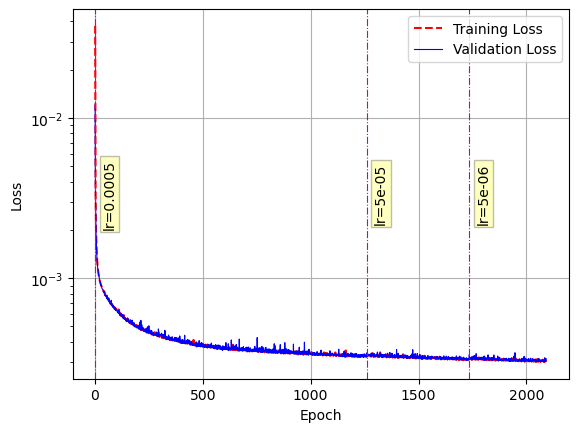

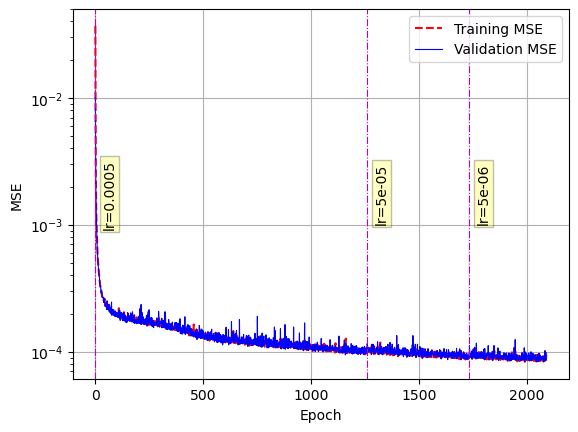

<Figure size 640x480 with 0 Axes>

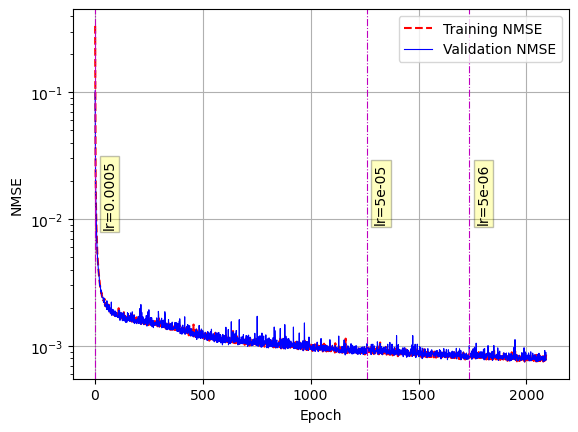

<Figure size 640x480 with 0 Axes>

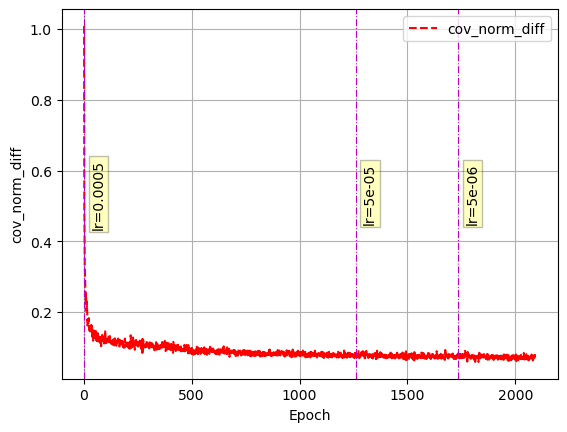

<Figure size 640x480 with 0 Axes>

In [34]:
# plotting losses
dir_name_plot = dir_name_ae + '/plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_plot + '{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
)
plt.savefig(dir_name_plot+'/MSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
)
plt.savefig(dir_name_plot+'/NMSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_cov_loss_hist,
    val_loss=None,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=[r"cov_norm_diff"],
    xlabel='Epoch',
    ylabel=r"cov_norm_diff",
    plot_type='plot',
)
plt.savefig(dir_name_plot+'/train_cov_loss_hist.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()

In [35]:
reconstructed_data = ae_net.predict(all_data_og)

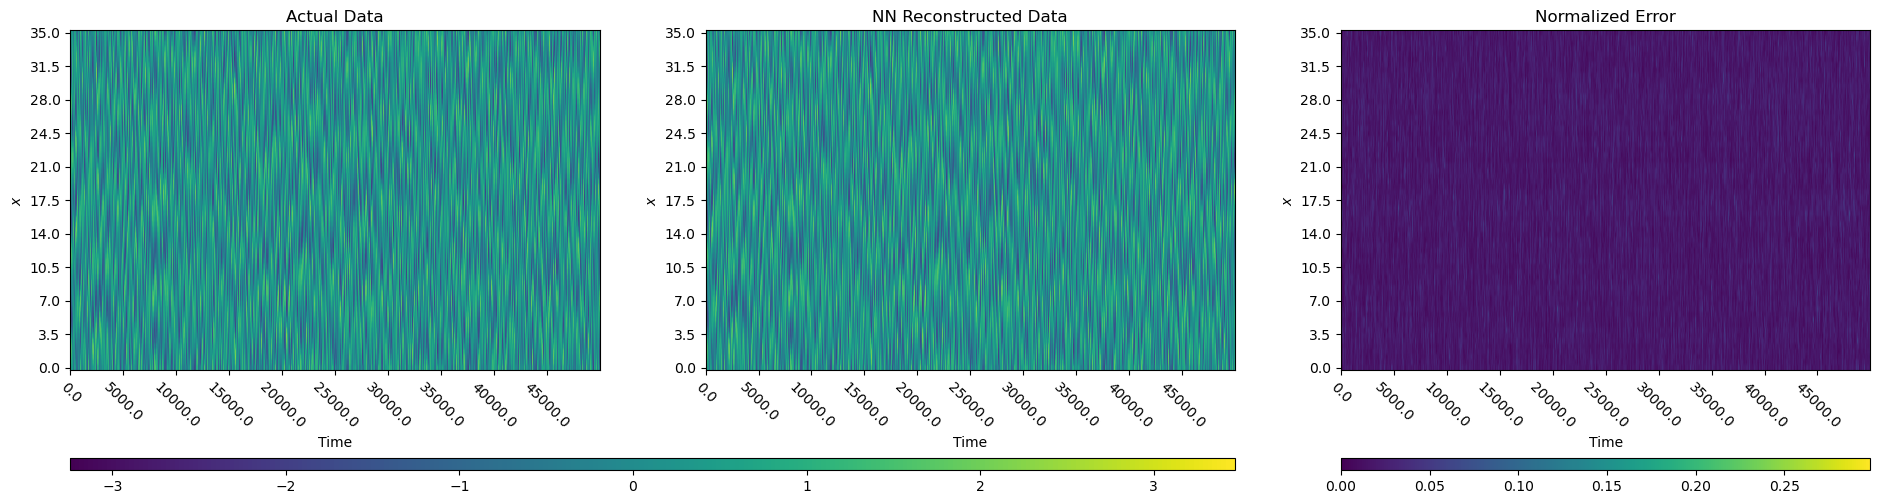

In [36]:
plot_reconstructed_data_KS(
    boundary_idx_arr_og,
    dir_name_ae,
    all_data_og,
    reconstructed_data, delta_t, xgrid,
    save_figs=False,
    normalization_constant_arr=normalization_constant_arr_aedata,
    xticks_snapto=xticks_snapto,
    num_yticks=11)

In [37]:
plot_reconstructed_data_KS(
    boundary_idx_arr_og,
    dir_name_ae,
    all_data_og,
    reconstructed_data, delta_t, xgrid,
    save_figs=True,
    normalization_constant_arr=normalization_constant_arr_aedata,
    xticks_snapto=xticks_snapto,
    num_yticks=11)

In [38]:
time_to_plot = 20



plot_reconstructed_data_KS(
    boundary_idx_arr_og,
    dir_name_ae,
    all_data_og,
    reconstructed_data, delta_t, xgrid,
    save_figs=True,
    normalization_constant_arr=normalization_constant_arr_aedata,
    xticks_snapto=xticks_snapto,
    num_yticks=11)

In [39]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data_og)

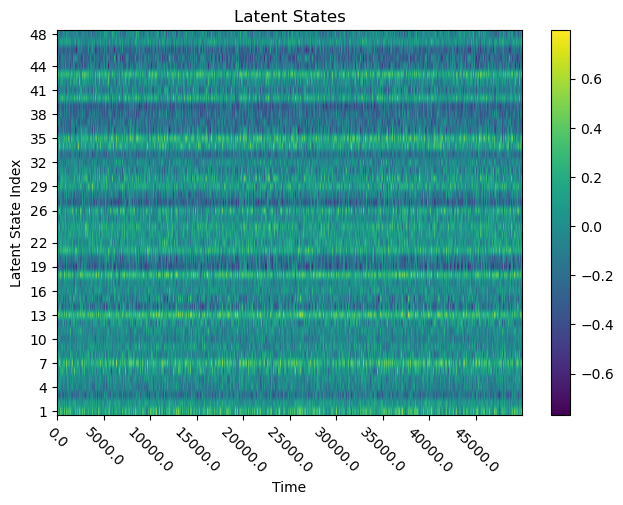

In [40]:
plot_latent_states_KS(
    boundary_idx_arr_og,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=xticks_snapto,
    num_yticks=16,
    save_figs=False)

In [41]:
plot_latent_states_KS(
    boundary_idx_arr_og,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=xticks_snapto,
    num_yticks=11,
    save_figs=True)

In [42]:
# ae_net.summary()

In [43]:
n = len(boundary_idx_arr)
num_digits_n = int(np.log10(n)+1)

# '''
num_cols = 4
num_rows = (latent_states_all.shape[-1] + num_cols-1)//num_cols
factor = 1
num_modes = xgrid.shape[0]

prev_idx = 0
for i in range(n):
    lyap_time = lyapunov_time_arr[i]
    start_time = 0
    plot_time = 20*lyap_time
    # next_idx = boundary_idx_arr[i]
    prev_idx += int((start_time + 0.5*delta_t)//delta_t) 
    next_idx = prev_idx + int((plot_time+0.5*delta_t)//delta_t)
    fig, ax = plt.subplots(num_rows, num_cols, sharex=False, figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
    N = next_idx - prev_idx
    # print(N)
    input_time = (start_time + np.arange(0, N)*delta_t)/lyap_time
    
    # temp = N*delta_t
    # chosen_interval = temp//10
    # sn = np.format_float_scientific(chosen_interval, exp_digits=4)
    # # print(temp, sn)
    # snap = 25*np.round(10*float(sn[0:-6])/25)/10
    # if snap == 0:
    #     snap = 0.1
    # snap *= float('1'+sn[-6:])
    # xticks_snapto = int(snap*np.round(chosen_interval/snap))

    for j in range(latent_states_all.shape[-1]):
        row = j // num_cols
        col = j % num_cols
        ax[row, col].plot(input_time, latent_states_all[prev_idx:next_idx, j])
        # ax[j].plot(input_time, D_reconstructed_list[i][prev_idx:next_idx], color='C0', label='Reconstructed Data')
        # num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        # xticks = int((start_time + 0.5*delta_t)//delta_t) + np.arange(0, N+1, int((xticks_snapto+0.5*delta_t)//delta_t))
        # print(xticks)
        # ax[j].set_xticks(ticks=np.round(xticks*delta_t, 1))
        # ax[j].set_xticklabels('')
        ax[row, col].tick_params(axis='x', rotation=270+45)
        ax[row, col].set_ylabel('latent state {}'.format(j+1))
        ax[row, col].set_xlabel(r'Time$^+$')
        ax[row, col].grid(True)

    # yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
    # yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
    # ax.set_yticks(ticks=yticks)
    # ax.set_yticklabels(yticklabels)

    # ax[-1].set_xlabel(r'Time$^+$')
    # ax[0].legend()
    # ax.title.set_text(r'Latent States')
    # if ax_titles_list is not None:
    #     ax.title.set_text(ax_titles_list[i])
    # else:
    # ax.title.set_text(r'Case '+str(i+1))

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle('Case '+str(i+1), size=16)
    
    fig.savefig(dir_name_plot+'/LatentSpace-Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
    fig.clear()
    plt.close()
    
    print('')

    prev_idx = boundary_idx_arr[i]

# KE and Dissipation

In [44]:
save_dir = dir_name_ae+dir_sep+'plots'
# save_dir = None

In [45]:
# Time evolution of Kinetic Energy
KE_org_list = []
KE_reconstructed_list = []
KE_nrmse = []

if normalizeforae_flag == True:
    rescaled_org_data = all_data_og[:, 0:xgrid.shape[0]]#.copy()
    rescaled_recon_data = reconstructed_data[:, 0:xgrid.shape[0]]#.copy()
    for i in range(xgrid.shape[0]):
        rescaled_org_data[:, i] *= normalization_constant_arr_aedata[1, i]
        rescaled_org_data[:, i] += normalization_constant_arr_aedata[0, i]
        rescaled_recon_data[:, i] *= normalization_constant_arr_aedata[1, i]
        rescaled_recon_data[:, i] += normalization_constant_arr_aedata[0, i]
else:
    rescaled_org_data = all_data_og[:, 0:xgrid.shape[0]]
    rescaled_recon_data = reconstructed_data[:, 0:xgrid.shape[0]]

if normalize_flag_ogdata == True:
    for i in range(xgrid.shape[0]):
        rescaled_org_data[:, i] *= normalization_constant_arr_ogdata[1, i]
        rescaled_org_data[:, i] += normalization_constant_arr_ogdata[0, i]
        rescaled_recon_data[:, i] *= normalization_constant_arr_ogdata[1, i]
        rescaled_recon_data[:, i] += normalization_constant_arr_ogdata[0, i]

begin_idx = 0
for i in range(len(boundary_idx_arr_og)):
    KE_org = np.sum(rescaled_org_data[begin_idx:boundary_idx_arr_og[i], 1:-1]**2, axis=1)
    KE_org += 0.5*(rescaled_org_data[begin_idx:boundary_idx_arr_og[i], 0]**2)
    KE_org += 0.5*(rescaled_org_data[begin_idx:boundary_idx_arr_og[i], -1]**2)
    KE_org /= xgrid.shape[0]-1
    KE_org_list.append(KE_org)
    
    KE_recon = np.sum(rescaled_recon_data[begin_idx:boundary_idx_arr_og[i], 1:-1]**2, axis=1)
    KE_recon += 0.5*(rescaled_recon_data[begin_idx:boundary_idx_arr_og[i], 0]**2)
    KE_recon += 0.5*(rescaled_recon_data[begin_idx:boundary_idx_arr_og[i], -1]**2)
    KE_recon /= xgrid.shape[0]-1
    KE_reconstructed_list.append(KE_recon)

    KE_rmse = np.mean((KE_recon - KE_org)**2)**0.5
    KE_mean = np.mean(KE_org)
    KE_rmse_normalized = KE_rmse/KE_mean
    KE_nrmse.append(KE_rmse_normalized)
    
    print('Case {} - KE_nrmse : {}'.format(i+1, KE_rmse_normalized))

    begin_idx = boundary_idx_arr_og[i]

Case 1 - KE_nrmse : 0.014123865979419128


In [46]:
n = len(boundary_idx_arr_og)
num_digits_n = int(np.log10(n)+1)

# '''
num_cols = 1
num_rows = 1
factor = 1

num_modes = xgrid.shape[0]

prev_idx = 0
for i in range(n):
    lyap_time = lyapunov_time_arr[i]
    print(lyap_time)
    start_time = 0
    plot_time = 20*lyap_time
    # next_idx = boundary_idx_arr_og[i]
    prev_idx += int((start_time + 0.5*delta_t)//delta_t) 
    next_idx = prev_idx + int((plot_time+0.5*delta_t)//delta_t)
    fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
    N = next_idx - prev_idx
    # print(N)
    input_time = (start_time + np.arange(0, N)*delta_t)/lyap_time

    # temp = N*delta_t
    # chosen_interval = temp//10
    # sn = np.format_float_scientific(chosen_interval, exp_digits=4)
    # # print(temp, sn)
    # snap = 25*np.round(10*float(sn[0:-6])/25)/10
    # if snap == 0:
    #     snap = 0.1
    # snap *= float('1'+sn[-6:])
    # xticks_snapto = int(snap*np.round(chosen_interval/snap))

    # prev_idx = boundary_idx_arr_og[i] - (next_idx-prev_idx)
    # next_idx = boundary_idx_arr_og[i]
    
    ax.plot(input_time, KE_org_list[i][prev_idx:next_idx], color='k', label='Original Data')
    ax.plot(input_time, KE_reconstructed_list[i][prev_idx:next_idx], color='C0', label='Reconstructed Data')
    # num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
    # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
    # xticks = int((start_time + 0.5*delta_t)//delta_t) + np.arange(0, N+1, int((xticks_snapto+0.5*delta_t)//delta_t))
    # print(xticks)
    # ax.set_xticks(ticks=np.round(xticks*delta_t, 1))
    # ax.set_xticklabels(np.round(xticks*delta_t, 1))
    ax.tick_params(axis='x', rotation=270+45)

    # yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
    # yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
    # ax.set_yticks(ticks=yticks)
    # ax.set_yticklabels(yticklabels)

    ax.set_xlabel(r'Time$^+$')
    ax.set_ylabel(r'$KE$')
    ax.grid(True)
    ax.legend()
    # ax.title.set_text(r'Latent States')
    # if ax_titles_list is not None:
    # ax.title.set_text(ax_titles_list[i])
    # else:
    ax.title.set_text(r'Case '+str(i+1))

    text_xy = [0.05, 0.05]
    ax.text(
        text_xy[0],
        text_xy[1],
        'latent space dimensions : {}'.format(
            latent_states_all.shape[1],
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
            alpha=0.8
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='left',
        verticalalignment='bottom'
    )
    
    # plt.colorbar(im)
    if save_dir is not None:
        fig.savefig(save_dir+dir_sep+'KE-Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
        fig.clear()
        plt.close()
    else:
        plt.show()
        print('')

    prev_idx = next_idx

15.466301


In [47]:
def compute_laplace_operator(
        data,
        xgrid
    ):
    from scipy.fft import fft, ifft, fftfreq
    M = xgrid.shape[0]
    length = xgrid[-1]
    k = fftfreq(M) * M * 2*np.pi/length
    laplace_operated_data = data[:, 0:M].copy()
    for i in range(data.shape[0]):
        v = fft(data[i, 0:M])
        v = k*k*v
        laplace_operated_data[i, :] = np.real(ifft(v))
    return laplace_operated_data

In [48]:
# Time evolution of Dissipation
D_org_list = []
D_reconstructed_list = []
D_nrmse = []

begin_idx = 0
for i in range(len(boundary_idx_arr_og)):
    temp = compute_laplace_operator(rescaled_org_data[begin_idx:boundary_idx_arr_og[i]], xgrid)
    D_org = np.sum(temp[:, 1:-1]**2, axis=1)
    D_org += 0.5*(temp[:, 0]**2)
    D_org += 0.5*(temp[:, -1]**2)
    D_org /= xgrid.shape[0]-1
    D_org_list.append(D_org)
    
    temp = compute_laplace_operator(rescaled_recon_data[begin_idx:boundary_idx_arr_og[i]], xgrid)
    D_recon = np.sum(temp[:, 1:-1]**2, axis=1)
    D_recon += 0.5*(temp[:, 0]**2)
    D_recon += 0.5*(temp[:, -1]**2)
    D_recon /= xgrid.shape[0]-1
    D_reconstructed_list.append(D_recon)
    
    D_rmse = np.mean((D_recon - D_org)**2)**0.5
    D_mean = np.mean(D_org)
    D_rmse_normalized = D_rmse/D_mean
    D_nrmse.append(D_rmse_normalized)
    
    print('Case {} - D_nrmse : {}'.format(i+1, D_rmse_normalized))
    
    begin_idx = boundary_idx_arr_og[i]

Case 1 - D_nrmse : 0.037352415206805


In [49]:
n = len(boundary_idx_arr_og)
num_digits_n = int(np.log10(n)+1)

# '''
num_cols = 1
num_rows = 1
factor = 1
num_modes = xgrid.shape[0]

prev_idx = 0
for i in range(n):
    lyap_time = lyapunov_time_arr[i]
    start_time = 0
    plot_time = 20*lyap_time
    # next_idx = boundary_idx_arr_og[i]
    prev_idx += int((start_time + 0.5*delta_t)//delta_t) 
    next_idx = prev_idx + int((plot_time+0.5*delta_t)//delta_t)
    fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
    N = next_idx - prev_idx
    # print(N)
    input_time = (start_time + np.arange(0, N)*delta_t)/lyap_time
    
    # temp = N*delta_t
    # chosen_interval = temp//10
    # sn = np.format_float_scientific(chosen_interval, exp_digits=4)
    # # print(temp, sn)
    # snap = 25*np.round(10*float(sn[0:-6])/25)/10
    # if snap == 0:
    #     snap = 0.1
    # snap *= float('1'+sn[-6:])
    # xticks_snapto = int(snap*np.round(chosen_interval/snap))

    ax.plot(input_time, D_org_list[i][prev_idx:next_idx], color='k', label='Original Data')
    ax.plot(input_time, D_reconstructed_list[i][prev_idx:next_idx], color='C0', label='Reconstructed Data')
    # num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
    # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
    # xticks = int((start_time + 0.5*delta_t)//delta_t) + np.arange(0, N+1, int((xticks_snapto+0.5*delta_t)//delta_t))
    # print(xticks)
    # ax.set_xticks(ticks=np.round(xticks*delta_t, 1))
    # ax.set_xticklabels(np.round(xticks*delta_t, 1))
    ax.tick_params(axis='x', rotation=270+45)

    # yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
    # yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
    # ax.set_yticks(ticks=yticks)
    # ax.set_yticklabels(yticklabels)

    ax.set_xlabel(r'Time$^+$')
    ax.set_ylabel(r'$D$')
    ax.grid(True)
    ax.legend()
    # ax.title.set_text(r'Latent States')
    # if ax_titles_list is not None:
    #     ax.title.set_text(ax_titles_list[i])
    # else:
    ax.title.set_text(r'Case '+str(i+1))

    text_xy = [0.05, 0.05]
    ax.text(
        text_xy[0],
        text_xy[1],
        'latent space dimensions : {}'.format(
            latent_states_all.shape[1],
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
            alpha=0.8
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='left',
        verticalalignment='bottom'
    )

    if save_dir is not None:
        fig.savefig(save_dir+'/Dissipation-Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
        fig.clear()
        plt.close()
    else:
        plt.show()
        print('')

    prev_idx = next_idx

In [50]:
np.savez(
    dir_name_ae+dir_sep+'KE_D_data',
    KE_org_list=KE_org_list,
    KE_reconstructed_list=KE_reconstructed_list,
    KE_nrmse=KE_nrmse,
    D_org_list=D_org_list,
    D_reconstructed_list=D_reconstructed_list,
    D_nrmse=D_nrmse,
    num_latent_states=[latent_states_all.shape[1]],
)

In [51]:
# x = np.linspace(-5, 5, 100)

# a = 1 #- np.exp(-2)

# modified_relu = lambda x : tf.keras.activations.relu(x+a).numpy()-a
# elu = lambda x : tf.keras.activations.elu(x)

# y1 = modified_relu(x)
# y2 = elu(x)

# plt.plot(x, y1, label='modified_relu')
# plt.plot(x, y2, label='elu')
# plt.legend()
# plt.grid(True)
# plt.show()

In [52]:
ae_net.decoder_layers_list[-1].weights

[<tf.Variable 'dense_7/kernel:0' shape=(128, 64) dtype=float32, numpy=
 array([[-0.03840819, -0.03095892, -0.01371064, ..., -0.05606556,
         -0.03810107, -0.03531908],
        [-0.01913476, -0.01548428, -0.05538288, ..., -0.10771737,
         -0.09654552, -0.05510126],
        [-0.06722008, -0.07312427, -0.03736983, ...,  0.04687869,
          0.00067502, -0.0377259 ],
        ...,
        [-0.13461637, -0.16169322, -0.02953918, ...,  0.05911989,
          0.07920747,  0.01686798],
        [ 0.05888478,  0.02450616,  0.00139015, ..., -0.04396027,
          0.05269464,  0.08526313],
        [ 0.07687609,  0.06342468,  0.04537843, ...,  0.05573035,
          0.0639606 ,  0.0710931 ]], dtype=float32)>,
 <tf.Variable 'dense_7/bias:0' shape=(64,) dtype=float32, numpy=
 array([ 0.01555825,  0.05385597,  0.06382014,  0.03364178, -0.03487787,
        -0.08166932, -0.0526212 ,  0.0214975 ,  0.06381146,  0.03540656,
        -0.02820409, -0.06760647, -0.06087273, -0.01962324,  0.0424157 ,
  

In [410]:
all_data_og_withoutAEnorm = all_data_og*normalization_constant_arr_aedata[1, :] + normalization_constant_arr_aedata[0, :]
reconstructed_data_withoutAEnorm = reconstructed_data*normalization_constant_arr_aedata[1, :] + normalization_constant_arr_aedata[0, :]

In [411]:
FourierCoeffs_og = fft.fft(all_data_og_withoutAEnorm[:, 0:numpoints_xgrid], axis=1)
energySpectrum_og = FourierCoeffs_og.real**2 + FourierCoeffs_og.imag**2
energySpectrum_og = np.mean(energySpectrum_og, axis=0)

In [412]:
FourierCoeffs_AE = fft.fft(reconstructed_data_withoutAEnorm[:, 0:numpoints_xgrid], axis=1)
energySpectrum_AE = FourierCoeffs_AE.real**2 + FourierCoeffs_AE.imag**2
energySpectrum_AE = np.mean(energySpectrum_AE, axis=0)

In [413]:
meancentereddata_og = all_data_og_withoutAEnorm[:, 0:numpoints_xgrid] - np.mean(all_data_og_withoutAEnorm[:, 0:numpoints_xgrid], axis=0)
# covmat_og = np.matmul(meancentereddata_og.transpose(), meancentereddata_og, dtype=FTYPE) / (meancentereddata_og.shape[0] - 1)
covmat_og = (meancentereddata_og.transpose() @ meancentereddata_og) / FTYPE(meancentereddata_og.shape[0] - 1)
eigvals_og = np.abs(np.linalg.eigvals(covmat_og))
# eigvals_og = np.linalg.eigvals(covmat_og)
eigvals_og = np.sort(eigvals_og)
eigvals_og = eigvals_og[::-1]

print(meancentereddata_og.dtype)
print(meancentereddata_og.transpose().dtype)
print(covmat_og.dtype)
print(eigvals_og.dtype)

float32
float32
float32
float32


In [414]:
meancentereddata_ae = reconstructed_data_withoutAEnorm[:, 0:numpoints_xgrid] - np.mean(reconstructed_data_withoutAEnorm[:, 0:numpoints_xgrid], axis=0)
covmat_ae = np.matmul(meancentereddata_ae.transpose(), meancentereddata_ae) / FTYPE(meancentereddata_ae.shape[0] - 1)
eigvals_ae = np.abs(np.linalg.eigvals(covmat_ae))
# eigvals_ae = np.linalg.eigvals(covmat_ae)
eigvals_ae = np.sort(eigvals_ae)
eigvals_ae = eigvals_ae[::-1]

print(meancentereddata_ae.dtype)
print(meancentereddata_ae.transpose().dtype)
print(covmat_ae.dtype)
print(eigvals_ae.dtype)

float32
float32
float32
float32


In [415]:
# all_data_og += podcentering_means

In [416]:
podcentering_means = np.mean(all_data_og_withoutAEnorm[:, 0:numpoints_xgrid], axis=0)
cov_matrix = covmat_og.copy()

print(podcentering_means.dtype)
print(cov_matrix.dtype)

float32
float32


In [417]:
eigenvals, eigenvecs = np.linalg.eig(cov_matrix)

print(eigenvals.dtype)
print(eigenvecs.dtype)

float32
float32


In [418]:
for i in range(len(eigenvals)):
    ev = eigenvals[i]
    if ev < 0.0:
        print('negative eigenval, something wrong, i : {}, ev : {}'.format(i, ev))
        # eigenvals[i] *= -1
        # eigenvecs[:, i] *= -1

negative eigenval, something wrong, i : 39, ev : -3.64032675861381e-05
negative eigenval, something wrong, i : 40, ev : -3.310665488243103e-05
negative eigenval, something wrong, i : 41, ev : -3.239923171349801e-05
negative eigenval, something wrong, i : 42, ev : -3.1302799470722675e-05
negative eigenval, something wrong, i : 44, ev : -2.3521004550275393e-05
negative eigenval, something wrong, i : 46, ev : -1.8383467249805108e-05
negative eigenval, something wrong, i : 47, ev : -1.7499156456324272e-05
negative eigenval, something wrong, i : 48, ev : -1.3360773664317094e-05
negative eigenval, something wrong, i : 49, ev : -1.2853149200964253e-05
negative eigenval, something wrong, i : 52, ev : -7.893988367868587e-06
negative eigenval, something wrong, i : 53, ev : -5.271660029393388e-06
negative eigenval, something wrong, i : 55, ev : -8.175255743481102e-07


In [419]:
sorted_idx = np.argsort(eigenvals)
eigenvals = eigenvals[sorted_idx]
eigenvecs = eigenvecs[:, sorted_idx]

In [420]:
pod_timeAvgEnergySpectrum = []
covmat_list_pod = []
eigvals_list_pod = []

num_latent_states = latent_space_dim
# num_latent_states = num_latent_states_list[i]
Wl = eigenvecs[:, -num_latent_states:]
Xl = all_data_og_withoutAEnorm[:, 0:numpoints_xgrid]-podcentering_means
Xl = np.matmul(Xl, Wl)
Xl = np.matmul(Xl, Wl.transpose())
# for i in range(numpoints_xgrid):
#     Xl[:, i] += podcentering_means[i]
Xl = Xl + podcentering_means
FourierCoeffs_pod = fft.fft(Xl, axis=1)
energySpectrum_pod = FourierCoeffs_pod.real**2 + FourierCoeffs_pod.imag**2
energySpectrum_pod = np.mean(energySpectrum_pod, axis=0)
pod_timeAvgEnergySpectrum.append(energySpectrum_pod)

meancentereddata_pod = Xl[:, 0:numpoints_xgrid] - np.mean(Xl[:, 0:numpoints_xgrid], axis=0)
covmat_pod = np.matmul(meancentereddata_pod.transpose(), meancentereddata_pod) / FTYPE(meancentereddata_pod.shape[0] - 1)
eigvals_pod = np.abs(np.linalg.eigvals(covmat_pod))
# eigvals_pod = np.linalg.eigvals(covmat_pod)
eigvals_pod = np.sort(eigvals_pod)
eigvals_pod = eigvals_pod[::-1]
covmat_list_pod.append(covmat_pod)
eigvals_list_pod.append(eigvals_pod)

print(Xl.dtype)
print(covmat_pod.dtype)
print(eigvals_pod.dtype)

float32
float32
float32


In [421]:
print('Amount of energy contained in reconstructed data')
print('------------------------------------------------')
print(' AE : {} %'.format(100*np.sum(energySpectrum_AE)/np.sum(energySpectrum_og)))
print('POD : {} %'.format(100*np.sum(pod_timeAvgEnergySpectrum[0])/np.sum(energySpectrum_og)))

Amount of energy contained in reconstructed data
------------------------------------------------
 AE : 99.50592548244693 %
POD : 100.00000310608644 %


In [422]:
k = fft.fftfreq(numpoints_xgrid, d=1/numpoints_xgrid)
idx = np.where(k<0)[0]
k[idx] += numpoints_xgrid
print(k)#*numpoints_xgrid*2*np.pi/xgrid[-1])

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63.]


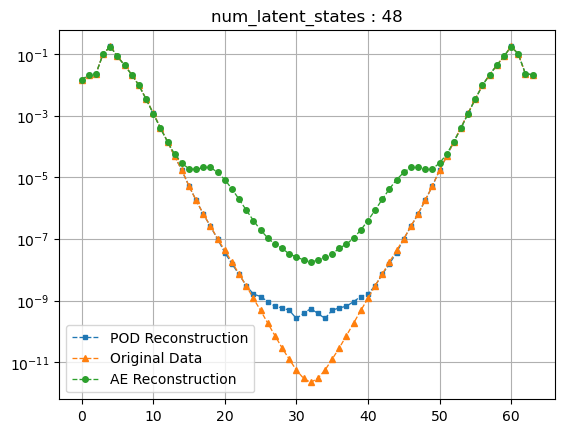

In [423]:
y1 = energySpectrum_og/np.sum(energySpectrum_og)
y2 = energySpectrum_AE/np.sum(energySpectrum_og)# np.sum(timeAvgEnergySpectrum[i])
y3 = pod_timeAvgEnergySpectrum[0]/np.sum(energySpectrum_og)# np.sum(pod_timeAvgEnergySpectrum[i])
plt.semilogy(k, y3, marker='s', markersize=3, linewidth=0.95, linestyle='--', label='POD Reconstruction')
plt.semilogy(k, y1, marker='^', markersize=4, linewidth=0.95, linestyle='--', label='Original Data')
plt.semilogy(k, y2, marker='o', markersize=4, linewidth=0.95, linestyle='--', label='AE Reconstruction')
# plt.ylim([5e-2,None])
plt.title('num_latent_states : {}'.format(num_latent_states))
plt.grid(True)
plt.legend()
plt.show()

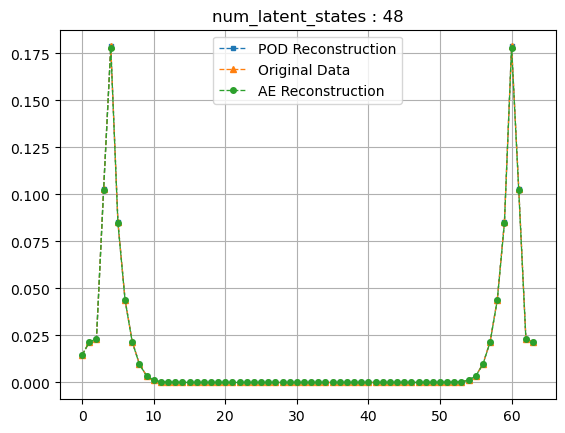

In [424]:
y1 = energySpectrum_og/np.sum(energySpectrum_og)
y2 = energySpectrum_AE/np.sum(energySpectrum_og)# np.sum(timeAvgEnergySpectrum[i])
y3 = pod_timeAvgEnergySpectrum[0]/np.sum(energySpectrum_og)# np.sum(pod_timeAvgEnergySpectrum[i])
plt.plot(k, y3, marker='s', markersize=3, linewidth=0.95, linestyle='--', label='POD Reconstruction')
plt.plot(k, y1, marker='^', markersize=4, linewidth=0.95, linestyle='--', label='Original Data')
plt.plot(k, y2, marker='o', markersize=4, linewidth=0.95, linestyle='--', label='AE Reconstruction')
plt.title('num_latent_states : {}'.format(num_latent_states))
plt.grid(True)
plt.legend()
plt.show()

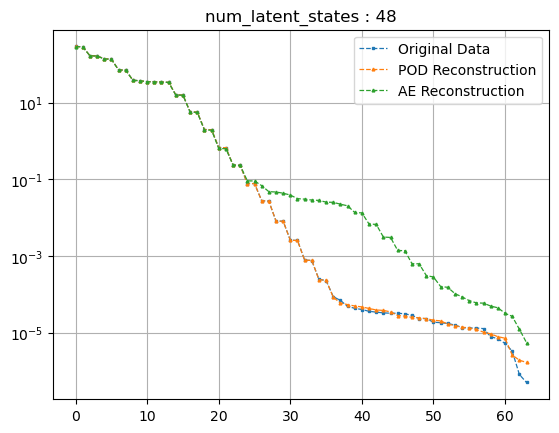

In [425]:
fig_eigvals, ax_eigvals = plt.subplots()
ax_eigvals.semilogy(eigvals_og, linestyle='--', marker='s', linewidth=0.9, markersize=2)
ax_eigvals.semilogy(eigvals_list_pod[0], linestyle='--', marker='^', linewidth=0.9, markersize=2)
ax_eigvals.semilogy(eigvals_ae, linestyle='--', marker='^', linewidth=0.9, markersize=2)
ax_eigvals.grid(True)
ax_eigvals.legend([r'Original Data', r'POD Reconstruction', r'AE Reconstruction'])
ax_eigvals.set_axisbelow(True)
ax_eigvals.set_title('Eigenvalues of the covariance matrix')
plt.title('num_latent_states : {}'.format(num_latent_states))
plt.show()

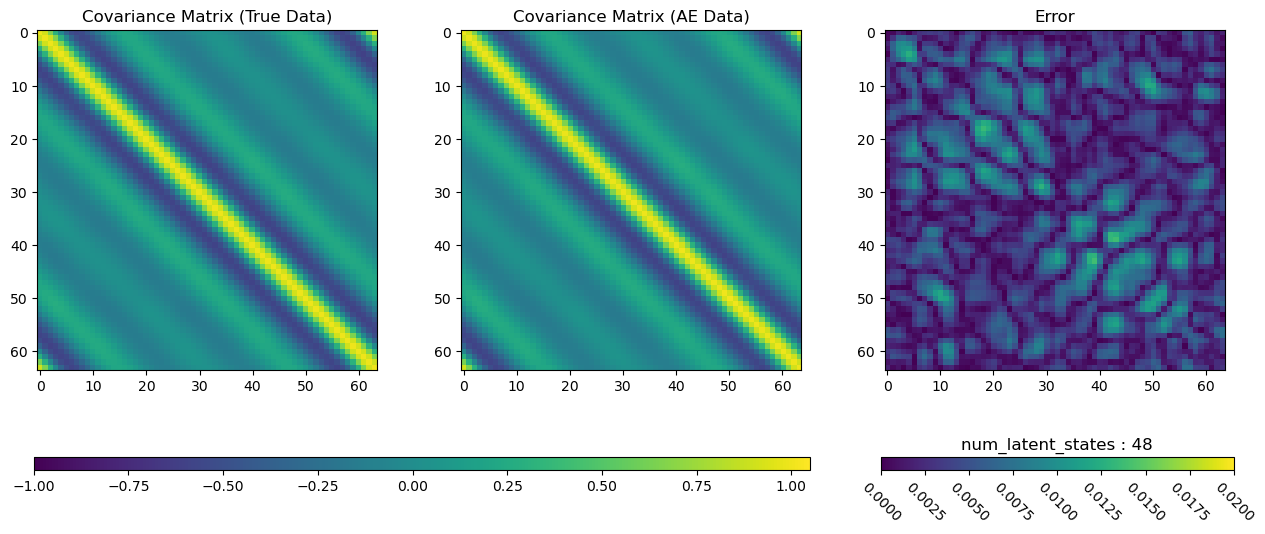

In [426]:
covmat_og_normd = np.divide(np.transpose(covmat_og), np.diag(covmat_og)).transpose()

fig_covmat = plt.figure(figsize=(5.0*3, 5.0*1))
subplot1 = 1
subplot2 = subplot1 + 1

covmat_ae_normd = np.divide(np.transpose(covmat_ae), np.diag(covmat_og)).transpose()

vmin_snap = 0.05
vmax_snap = 0.05
vmin = np.min([
    covmat_og_normd.min(),
    covmat_ae_normd.min()
])
vmin = min(vmin, -1.0)
vmin = -vmin_snap*np.round(-vmin/vmin_snap + 0.5)
vmax = np.max([
    covmat_og_normd.max(),
    covmat_ae_normd.max()
])
vmax = max(vmax, 1.0)
vmax = vmax_snap*np.round(vmax/vmax_snap + 0.5)

# plotting the original data
ax_covmat_orig = fig_covmat.add_subplot(1, 3, subplot1)
im_orig = ax_covmat_orig.imshow(
    covmat_og_normd,
    aspect='equal',
    origin='upper',
    vmin=vmin,
    vmax=vmax
)
ax_covmat_orig.title.set_text('Covariance Matrix (True Data)')
# xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
# ax_covmat_orig.set_xticks(ticks=xticks)
# ax_covmat_orig.set_xticklabels(np.round(xticks*delta_t, 1))
# ax_covmat_orig.tick_params(axis='x', rotation=270+45)
# yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
# yticklabels = np.round(xgrid[0]+np.linspace(0, 1, yticks.shape[0])*(xgrid[-1]-xgrid[0]), 2)
# ax_covmat_orig.set_yticks(ticks=yticks)
# ax_covmat_orig.set_yticklabels(yticklabels)
# ax_covmat_orig.set_xlabel(xlabel)
# ax_covmat_orig.set_ylabel(ylabel)

# plotting the predicted data
ax_covmat_predict = fig_covmat.add_subplot(1, 3, subplot2, sharey=ax_covmat_orig, sharex=ax_covmat_orig)
im_predict = ax_covmat_predict.imshow(
    covmat_ae_normd,
    aspect='equal',
    origin='upper',
    vmin=vmin,
    vmax=vmax
)
ax_covmat_predict.title.set_text('Covariance Matrix (AE Data)')
# ax_covmat_predict.tick_params(axis='x', rotation=270+45)
# ax_covmat_predict.set_xlabel(xlabel)
# ax_covmat_predict.set_ylabel(ylabel)

# subplots adjustment to account for colorbars
fig_covmat.subplots_adjust(
    bottom=0.2,
    left=0.1,
)

# original data and recon data colorbar
cb_xbegin = ax_covmat_orig.transData.transform([0, 0])
cb_xbegin = fig_covmat.transFigure.inverted().transform(cb_xbegin)[0]
cb_xend = ax_covmat_predict.transData.transform([covmat_ae_normd.shape[-1], 0])
cb_xend = fig_covmat.transFigure.inverted().transform(cb_xend)[0]

cb_ax = fig_covmat.add_axes([cb_xbegin, 0.0, cb_xend-cb_xbegin, 0.025])
cbar = fig_covmat.colorbar(im_predict, cax=cb_ax, orientation='horizontal')

# computing the normalized error
subplot3 = subplot2+1
error = np.abs(covmat_og_normd-covmat_ae_normd)
vmax_error_snap = 0.02
vmax_error = np.max(error)
vmax_error = vmax_error_snap*np.round(vmax_error/vmax_error_snap + 0.5)
# error = 100*error / np.abs(pod_covmat_dataout)
# plotting the normalized error
ax_covmat_error = fig_covmat.add_subplot(1, 3, subplot3, sharey=ax_covmat_orig, sharex=ax_covmat_orig)
im_error = ax_covmat_error.imshow(
    error,
    aspect='equal',
    origin='upper',
    vmin=0.0,
    vmax=vmax_error
)
ax_covmat_error.title.set_text(r'Error')
# ax_error.tick_params(axis='x', rotation=270+45)
# ax_error.set_xlabel(xlabel)
# ax_error.set_ylabel(ylabel)

# error colorbar
cbe_xbegin = ax_covmat_error.transData.transform([0, 0])
cbe_xbegin = fig_covmat.transFigure.inverted().transform(cbe_xbegin)[0]
cbe_xend = ax_covmat_error.transData.transform([covmat_ae_normd.shape[-1], 0])
cbe_xend = fig_covmat.transFigure.inverted().transform(cbe_xend)[0]
error_cb_ax = fig_covmat.add_axes([cbe_xbegin, 0.0, cbe_xend-cbe_xbegin, 0.025])
error_cb_ax.tick_params(axis='x', rotation=270+45)
cbar_error = fig_covmat.colorbar(im_error, cax=error_cb_ax, orientation='horizontal')
plt.title('num_latent_states : {}'.format(num_latent_states))
plt.show()